In [2]:
!conda install -c conda-forge pyrender trimesh imageio -y

Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/s5701147/.pyenv/versions/anaconda3-2024.06-1

  added / updated specs:
    - imageio
    - pyrender
    - trimesh


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.4.26  |       hbd8a1cb_0         149 KB  conda-forge
    certifi-2025.4.26          |     pyhd8ed1ab_0         154 KB  conda-forge
    conda-24.11.3              |  py312h7900ff3_0         1.1 MB  conda-forge
    dataclasses-0.8            |     pyhc8e2a94_3          10 KB  conda-forge
    ffmpeg-4.4.0               |       h6987444_4         9.9 MB  conda-forge
    fontconfig-2.14.2          |       h14ed4e7_0         266 KB  conda-forge
    freetype-py-2.5.1          |     pyhd8ed1ab_1          64 KB  conda-forge
    gmp-6.2.1                  |       h58526e2_0         806

In [1]:
import numpy as np
import pyrender
import trimesh
import imageio
import os
import json

In [2]:
def makedir(path):
    folder = os.path.exists(path)
    if not folder:
        os.mkdir(path)

In [3]:
connections = [(15,12),(12,17),(17,19),(21,19),(12,16),(16,18),(18,20),(14,13),(12,9),(9,6),(6,3),(3,0),(0,2),(0,1),(2,1),(2,5),(1,4),(5,8),(4,7),(8,11),(7,10)]

def create_cylinder_between_points(p1, p2, radius):
    # Create a unit cylinder centered on the origin
    cyl_length = np.linalg.norm(p2 - p1)
    cylinder = trimesh.creation.cylinder(radius, cyl_length, sections=32)
    
    # Align the cylinder with the line from p1 to p2
    mid_point = (p1 + p2) / 2
    vec_dist = p2 - p1
    axis_vector = vec_dist / np.linalg.norm(vec_dist)
    up_vector = np.array([0, 0, 1])
    cross_vec = np.cross(up_vector, axis_vector)
    dot_product = np.dot(up_vector, axis_vector)
    if np.linalg.norm(cross_vec) == 0:
        cross_vec = np.array([1, 0, 0])
    axis_angle = np.arccos(dot_product)
    rot_matrix = trimesh.transformations.rotation_matrix(axis_angle, cross_vec, point=mid_point)
    
    # Apply the transform to the cylinder
    cylinder.apply_translation(mid_point)
    cylinder.apply_transform(rot_matrix)
    
    return cylinder

In [4]:
def clamp(value, min_value, max_value):
    return max(min_value, min(value, max_value))

def angle_between(v1, v2):
    unit_v1 = v1 / np.linalg.norm(v1)
    unit_v2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(unit_v1, unit_v2)
    angle_rad = np.arccos(clamp(dot_product, -1.0, 1.0))  # Clamp to avoid floating point errors
    return angle_rad

def compute_scale(fov, aspect):
    # This is a placeholder calculation for Sx and Sy based on typical perspective projection
    Sx = 1.0 / np.tan(fov * 0.5)  # Assuming fov is in radians
    Sy = Sx * aspect
    return Sx, Sy

def get_alpha(fov, aspect, pA, pB):
    Sx, Sy = compute_scale(fov, aspect)
    # Assuming pA and pB are tuples (x, y), and we just need their screen space projection
    pA3 = np.array([pA[0] / Sx, pA[1] / Sy, 1.0])
    pB3 = np.array([pB[0] / Sx, pB[1] / Sy, 1.0])
    # Calculate the angle in radians between the two vectors
    angle_rad = angle_between(pA3, pB3)
    # Clamp the angle value to the range (0.001, PI - 0.001)
    alpha = clamp(angle_rad, 0.001, np.pi - 0.001)
    return alpha

In [5]:
import math
def projectY(v3):
    # Assuming projectY drops the y component and returns a Vector2
    return np.array([v3[0], v3[2]])

def rotate90(v2):
    # Rotates a Vector2 by 90 degrees
    return np.array([-v2[1], v2[0]])

def unprojectY(v2):
    # Assuming unprojectY takes a Vector2 (x, z) and returns a Vector3 (x, 0, z)
    return np.array([v2[0], 0, v2[1]])

def compute_distance_from_A(AB, alpha, theta):
    return (AB * math.sin(alpha + theta / 2.0)) / math.sin(alpha)

In [6]:
from scipy.spatial.transform import Rotation as R
def toric2euclidean(camera_toric, wposA, wposB):
    ldxy = (camera_toric["L2Dy"] + camera_toric["R2Dy"]) / 2.0
    alpha = get_alpha(camera_toric["FOV"], camera_toric["Aspect"], [camera_toric["L2Dx"], camera_toric["L2Dy"]],
                      [camera_toric["R2Dx"], camera_toric["R2Dy"]])
    theta = camera_toric["Theta"]
    phi = camera_toric["Phi"]

    vecAB = wposB - wposA
    AB = np.linalg.norm(vecAB)

    n = vecAB
    n2 = np.array([vecAB[0], vecAB[2]])  # Project onto Y plane
    n2 = np.array([-n2[1], n2[0]])  # Rotate 90 degrees in the Y plane
    z = np.array([n2[0], 0, n2[1]])  # Unproject

    vecABnorm = n / np.linalg.norm(n)
    qP = R.from_rotvec(phi * vecABnorm)  # Rotation around vecABnorm by phi
    beta = theta / 2

    t = np.cross(z, n)
    # t = t / np.linalg.norm(t)
    qT = R.from_rotvec(beta * t)  # Rotation around t by beta
    d = compute_distance_from_A(AB, alpha, theta)

    if alpha <= 0.01 and theta > 5.0:
        d = 0.0

    res = qP.apply(qT.apply(vecAB))  # Apply qT to vecAB and then apply qP to the result
    res *= d
    res /= AB
    print("result:", res)
    res += wposA
    # if left_name != "dummy" and right_name != "dummy":
    # print("result:", camera_toric, left_name, wposA, right_name, wposB, res)
    return res


def toric2rotation(camera_toric, cam_pos, wposA, wposB):
    ldxy = (camera_toric["L2Dy"] + camera_toric["R2Dy"]) / 2.0
    alpha = get_alpha(camera_toric["FOV"], camera_toric["Aspect"],
                      [camera_toric["L2Dx"], camera_toric["L2Dy"]],
                      [camera_toric["R2Dx"], camera_toric["R2Dy"]])
    Sx, Sy = compute_scale(camera_toric["FOV"], camera_toric["Aspect"])
    pA3 = np.array([camera_toric["L2Dx"] / Sx, ldxy / Sy, 1.0])
    pB3 = np.array([camera_toric["R2Dx"] / Sx, ldxy / Sy, 1.0])
    pA3 = pA3 / np.linalg.norm(pA3)
    pB3 = pB3 / np.linalg.norm(pB3)

    fwd = pA3 + pB3
    fwd = fwd / np.linalg.norm(fwd)
    up = np.cross(pA3, pB3)
    up = up / np.linalg.norm(up)
    right = np.cross(fwd, up)
    right = right / np.linalg.norm(right)
    up = np.cross(right, fwd)
    up = up / np.linalg.norm(up)

    pA4 = wposA - cam_pos
    pB4 = wposB - cam_pos
    pA4 = pA4 / np.linalg.norm(pA4)
    pB4 = pB4 / np.linalg.norm(pB4)
    fwd2 = pA4 + pB4
    fwd2 = fwd2 / np.linalg.norm(fwd2)
    up2 = np.array([0.0, 1.0, 0.0])
    right2 = np.cross(fwd2, up2)
    right2 = right2 / np.linalg.norm(right2)
    up2 = np.cross(right2, fwd2)
    up2 = up2 / np.linalg.norm(up2)

    # Create rotation matrices
    rotation_matrix = np.column_stack((right, up, fwd))
    rotation_matrix2 = np.column_stack((right2, up2, fwd2))

    # Compute the inverse of the first rotation matrix
    inverse_rotation_matrix = np.linalg.inv(rotation_matrix)

    # Apply the inverse rotation to the second set of axes
    new_axes = rotation_matrix2 @ inverse_rotation_matrix

    new_right = new_axes[:, 0]
    new_up = new_axes[:, 1]
    new_fwd = new_axes[:, 2]

    rot_trans = np.eye(4)
    rot_trans[0, :3] = new_right
    rot_trans[1, :3] = new_up
    rot_trans[2, :3] = new_fwd

    return (rot_trans[0][:3], rot_trans[1][:3], rot_trans[2][:3])

In [7]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

def draw_camera_viewing_cone(ax, camera_cur_pos, rot_trans, rotation_up, fov=30.0, aspect=1.67/2.5, near=0.0, far=2.0):
    global camera_path
    # Calculate the half-angles of the FOV
    half_fov = np.deg2rad(fov) / 2.0
    half_horizontal_fov = 2 * np.arctan(np.tan(half_fov) * aspect)

    # Calculate the near and far plane dimensions
    near_height = 2 * np.tan(half_fov) * near
    near_width = 2 * np.tan(half_horizontal_fov) * near
    far_height = 2 * np.tan(half_fov) * far
    far_width = 2 * np.tan(half_horizontal_fov) * far

    # Transform the frustum corners by the transformation matrix
    transformed_corners = np.array([
        camera_cur_pos + rot_trans[0] *  near_width / 2 + rot_trans[1] * near_height / 2 + rot_trans[2] * near,
        camera_cur_pos - rot_trans[0] *  near_width / 2 + rot_trans[1] * near_height / 2 + rot_trans[2] * near,
        camera_cur_pos - rot_trans[0] *  near_width / 2 - rot_trans[1] * near_height / 2 + rot_trans[2] * near,
        camera_cur_pos + rot_trans[0] *  near_width / 2 - rot_trans[1] * near_height / 2 + rot_trans[2] * near,
        camera_cur_pos + rot_trans[0] *  far_width / 2 + rot_trans[1] * far_height / 2 + rot_trans[2] * far,
        camera_cur_pos - rot_trans[0] *  far_width / 2 + rot_trans[1] * far_height / 2 + rot_trans[2] * far,
        camera_cur_pos - rot_trans[0] *  far_width / 2 - rot_trans[1] * far_height / 2 + rot_trans[2] * far,
        camera_cur_pos + rot_trans[0] *  far_width / 2 - rot_trans[1] * far_height / 2 + rot_trans[2] * far,
    ])
    
    for i, pos in enumerate(transformed_corners):
        transformed_corners[i] = rotation_up.apply(pos)
        
    transformed_corners = transformed_corners[:,[0,2,1]]
    # Define the edges connecting the corners
    edges = [
        [transformed_corners[i] for i in [0,1,2,3,0]], # Near plane
        [transformed_corners[i] for i in [4,5,6,7,4]], # Far plane
        [transformed_corners[i] for i in [0,4]], # Side edges
        [transformed_corners[i] for i in [1,5]],
        [transformed_corners[i] for i in [2,6]],
        [transformed_corners[i] for i in [3,7]]
    ]

    # Draw the edges
    for edge in edges:
        ax.add_collection3d(Line3DCollection([edge], colors='k', linewidths=1.0, linestyles=':', alpha=0.05))

    # Optionally, draw the planes using a semi-transparent polygon
    planes = [
        [transformed_corners[i] for i in [0,1,2,3]], # Near plane
        [transformed_corners[i] for i in [4,5,6,7]], # Far plane
        [transformed_corners[i] for i in [0,1,5,4]], # Top plane
        [transformed_corners[i] for i in [2,3,7,6]], # Bottom plane
        [transformed_corners[i] for i in [0,3,7,4]], # Right plane
        [transformed_corners[i] for i in [1,2,6,5]]  # Left plane
    ]

    # Draw semi-transparent planes
    ax.add_collection3d(Poly3DCollection(planes, facecolors='cyan', linewidths=0.2, edgecolors='g', alpha=0.05))


In [8]:
import numpy as np
import pyrender
import trimesh
import imageio
import os
import json

def makedir(path):
    folder = os.path.exists(path)
    if not folder:
        os.mkdir(path)


connections = [(15, 12), (12, 17), (17, 19), (21, 19), (12, 16), (16, 18), (18, 20), (14, 13),
               (12, 9), (9, 6), (6, 3), (3, 0), (0, 2), (0, 1), (2, 1), (2, 5), (1, 4), (5, 8), (4, 7), (8, 11),
               (7, 10)]

def create_cylinder_between_points(p1, p2, radius):
    # Create a unit cylinder centered on the origin
    cyl_length = np.linalg.norm(p2 - p1)
    cylinder = trimesh.creation.cylinder(radius, cyl_length, sections=32)

    # Align the cylinder with the line from p1 to p2
    mid_point = (p1 + p2) / 2
    vec_dist = p2 - p1
    axis_vector = vec_dist / np.linalg.norm(vec_dist)
    up_vector = np.array([0, 0, 1])
    cross_vec = np.cross(up_vector, axis_vector)
    dot_product = np.dot(up_vector, axis_vector)
    if np.linalg.norm(cross_vec) == 0:
        cross_vec = np.array([1, 0, 0])
    axis_angle = np.arccos(dot_product)
    rot_matrix = trimesh.transformations.rotation_matrix(axis_angle, cross_vec, point=mid_point)

    # Apply the transform to the cylinder
    cylinder.apply_translation(mid_point)
    cylinder.apply_transform(rot_matrix)

    return cylinder

def clamp(value, min_value, max_value):
    return max(min_value, min(value, max_value))

def angle_between(v1, v2):
    unit_v1 = v1 / np.linalg.norm(v1)
    unit_v2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(unit_v1, unit_v2)
    angle_rad = np.arccos(clamp(dot_product, -1.0, 1.0))  # Clamp to avoid floating point errors
    return angle_rad

def compute_scale(fov, aspect):
    # This is a placeholder calculation for Sx and Sy based on typical perspective projection
    Sx = 1.0 / np.tan(fov * 0.5)  # Assuming fov is in radians
    Sy = Sx * aspect
    return Sx, Sy

def get_alpha(fov, aspect, pA, pB):
    Sx, Sy = compute_scale(fov, aspect)
    # Assuming pA and pB are tuples (x, y), and we just need their screen space projection
    pA3 = np.array([pA[0] / Sx, pA[1] / Sy, 1.0])
    pB3 = np.array([pB[0] / Sx, pB[1] / Sy, 1.0])
    # Calculate the angle in radians between the two vectors
    angle_rad = angle_between(pA3, pB3)
    # Clamp the angle value to the range (0.001, PI - 0.001)
    alpha = clamp(angle_rad, 0.001, np.pi - 0.001)
    return alpha

import math
def projectY(v3):
    # Assuming projectY drops the y component and returns a Vector2
    return np.array([v3[0], v3[2]])

def rotate90(v2):
    # Rotates a Vector2 by 90 degrees
    return np.array([-v2[1], v2[0]])

def unprojectY(v2):
    # Assuming unprojectY takes a Vector2 (x, z) and returns a Vector3 (x, 0, z)
    return np.array([v2[0], 0, v2[1]])

def compute_distance_from_A(AB, alpha, theta):
    return (AB * math.sin(alpha + theta / 2.0)) / math.sin(alpha)


from scipy.spatial.transform import Rotation as R


def toric2euclidean(camera_toric, wposA, wposB):
    # {'Aspect': 1.67, 'FOV': 45, 'L2Dx': -0.17440299987792968, 'L2Dy': 0.538460456000434, 'R2Dx': 0.15002721150716145,
    # 'R2Dy': 0.5941090619122541, 'Theta': 3.168821413364448, 'Phi': 0.00737336601272176}
    ldxy = (camera_toric["L2Dy"] + camera_toric["R2Dy"]) / 2.0
    alpha = get_alpha(camera_toric["FOV"], camera_toric["Aspect"],
                      [camera_toric["L2Dx"], camera_toric["L2Dy"]], [camera_toric["R2Dx"], camera_toric["R2Dy"]])
    # print(alpha)
    # print(camera_toric)
    # assert 1==2
    theta = camera_toric["Theta"]
    # theta = 4
    phi = camera_toric["Phi"]
    vecAB = wposB - wposA
    AB = np.linalg.norm(vecAB)

    n = vecAB
    n2 = np.array([vecAB[0], vecAB[2]])  # Project onto Y plane
    n2 = np.array([-n2[1], n2[0]])  # Rotate 90 degrees in the Y plane
    z = np.array([n2[0], 0, n2[1]])  # Unproject

    vecABnorm = n / AB
    qP = R.from_rotvec(phi * vecABnorm)  # Rotation around vecABnorm by phi
    beta = theta / 2

    t = np.cross(z, n)
    t = t / np.linalg.norm(t)
    qT = R.from_rotvec(beta * t)  # Rotation around t by beta
    d = compute_distance_from_A(AB, alpha, theta)

    if alpha <= 0.01 and theta > 5.0:
        d = 0.0
    # print(d)
    res = qP.apply(qT.apply(vecAB))  # Apply qT to vecAB and then apply qP to the result
    res *= d
    res /= AB
    # res *= math.sin(phi + beta)
    # print(math.sin(phi + beta), "-----", d / AB)

    res += wposA
    # print(res)
    return res

def toric2rotation(camera_toric, cam_pos, wposA, wposB):
    ldxy = (camera_toric["L2Dy"] + camera_toric["R2Dy"]) / 2.0
    alpha = get_alpha(camera_toric["FOV"], camera_toric["Aspect"],
                      [camera_toric["L2Dx"], camera_toric["L2Dy"]],
                      [camera_toric["R2Dx"], camera_toric["R2Dy"]])
    Sx, Sy = compute_scale(camera_toric["FOV"], camera_toric["Aspect"])
    pA3 = np.array([camera_toric["L2Dx"] / Sx, ldxy / Sy, 1.0])
    pB3 = np.array([camera_toric["R2Dx"] / Sx, ldxy / Sy, 1.0])
    pA3 = pA3 / np.linalg.norm(pA3)
    pB3 = pB3 / np.linalg.norm(pB3)

    fwd = pA3 + pB3
    fwd = fwd / np.linalg.norm(fwd)
    up = np.cross(pA3, pB3)
    up = up / np.linalg.norm(up)
    right = np.cross(fwd, up)
    right = right / np.linalg.norm(right)
    up = np.cross(right, fwd)
    up = up / np.linalg.norm(up)

    pA4 = wposA - cam_pos
    pB4 = wposB - cam_pos
    pA4 = pA4 / np.linalg.norm(pA4)
    pB4 = pB4 / np.linalg.norm(pB4)
    fwd2 = pA4 + pB4
    fwd2 = fwd2 / np.linalg.norm(fwd2)
    up2 = np.array([0.0, 1.0, 0.0])
    right2 = np.cross(fwd2, up2)
    right2 = right2 / np.linalg.norm(right2)
    up2 = np.cross(right2, fwd2)
    up2 = up2 / np.linalg.norm(up2)

    # Create rotation matrices
    rotation_matrix = np.column_stack((right, up, fwd))
    rotation_matrix2 = np.column_stack((right2, up2, fwd2))

    # Compute the inverse of the first rotation matrix
    inverse_rotation_matrix = np.linalg.inv(rotation_matrix)

    # Apply the inverse rotation to the second set of axes
    new_axes = rotation_matrix2 @ inverse_rotation_matrix

    new_right = new_axes[:, 0]
    new_up = new_axes[:, 1]
    new_fwd = new_axes[:, 2]

    rot_trans = np.eye(4)
    rot_trans[0, :3] = new_right
    rot_trans[1, :3] = new_up
    rot_trans[2, :3] = new_fwd

    return (rot_trans[0][:3], rot_trans[1][:3], rot_trans[2][:3])



from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection


def draw_camera_viewing_cone(ax, camera_cur_pos, rot_trans, rotation_up, fov=45.0, aspect=1.67 / 2.5, near=0.3,
                             far=1.2):
    #near = 0.0 far = 2.0
    global camera_path
    # Calculate the half-angles of the FOV
    half_fov = np.deg2rad(fov) / 2.0
    # half_horizontal_fov = 2 * np.arctan(np.tan(half_fov) * aspect)
    half_horizontal_fov = np.arctan(np.tan(half_fov) * aspect)

    # Calculate the near and far plane dimensions
    near_height = 2 * np.tan(half_fov) * near
    near_width = 2 * np.tan(half_horizontal_fov) * near
    far_height = 2 * np.tan(half_fov) * far
    far_width = 2 * np.tan(half_horizontal_fov) * far

    # Transform the frustum corners by the transformation matrix
    transformed_corners = np.array([
        camera_cur_pos + rot_trans[0] * near_width / 2 + rot_trans[1] * near_height / 2 + rot_trans[2] * near,
        camera_cur_pos - rot_trans[0] * near_width / 2 + rot_trans[1] * near_height / 2 + rot_trans[2] * near,
        camera_cur_pos - rot_trans[0] * near_width / 2 - rot_trans[1] * near_height / 2 + rot_trans[2] * near,
        camera_cur_pos + rot_trans[0] * near_width / 2 - rot_trans[1] * near_height / 2 + rot_trans[2] * near,
        camera_cur_pos + rot_trans[0] * far_width / 2 + rot_trans[1] * far_height / 2 + rot_trans[2] * far,
        camera_cur_pos - rot_trans[0] * far_width / 2 + rot_trans[1] * far_height / 2 + rot_trans[2] * far,
        camera_cur_pos - rot_trans[0] * far_width / 2 - rot_trans[1] * far_height / 2 + rot_trans[2] * far,
        camera_cur_pos + rot_trans[0] * far_width / 2 - rot_trans[1] * far_height / 2 + rot_trans[2] * far,
    ])

    # for i, pos in enumerate(transformed_corners):
    #     transformed_corners[i] = rotation_up.apply(pos)

    transformed_corners = transformed_corners[:, [0, 2, 1]]
    # Define the edges connecting the corners
    edges = [
        [transformed_corners[i] for i in [0, 1, 2, 3, 0]],  # Near plane
        [transformed_corners[i] for i in [4, 5, 6, 7, 4]],  # Far plane
        [transformed_corners[i] for i in [0, 4]],  # Side edges
        [transformed_corners[i] for i in [1, 5]],
        [transformed_corners[i] for i in [2, 6]],
        [transformed_corners[i] for i in [3, 7]]
    ]

    # Draw the edges
    for edge in edges:
        ax.add_collection3d(Line3DCollection([edge], colors='k', linewidths=1.0, linestyles=':', alpha=0.05))

    # Optionally, draw the planes using a semi-transparent polygon
    planes = [
        [transformed_corners[i] for i in [0, 1, 2, 3]],  # Near plane
        [transformed_corners[i] for i in [4, 5, 6, 7]],  # Far plane
        [transformed_corners[i] for i in [0, 1, 5, 4]],  # Top plane
        [transformed_corners[i] for i in [2, 3, 7, 6]],  # Bottom plane
        [transformed_corners[i] for i in [0, 3, 7, 4]],  # Right plane
        [transformed_corners[i] for i in [1, 2, 6, 5]]  # Left plane
    ]

    # Draw semi-transparent planes
    ax.add_collection3d(Poly3DCollection(planes, facecolors='cyan', linewidths=0.2, edgecolors='g', alpha=0.05))
def calculate_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def predict_shot_type(camera_pos, left_character, right_character):
    # Calculate the midpoint between the two characters
    midpoint = (left_character + right_character) / 2

    # Calculate the distance between the camera and the midpoint
    distance = calculate_distance(camera_pos, midpoint)
    # print(distance)

    # Define thresholds for shot types (these values are arbitrary and may need adjustment)
    close_up_threshold = 1.0  # Assuming the scene units are in meters
    medium_shot_threshold = 3.0

    # Classify the shot type
    if distance <= close_up_threshold:
        return "Close-up"
    elif distance <= medium_shot_threshold:
        return "Medium shot"
    else:
        return "Long shot"
    
import torch
import torch.nn as nn
    
# class SimpleNet(nn.Module):
#     def __init__(self):
#         super(SimpleNet, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(4, 8),
#             nn.ReLU(),
#             nn.Linear(8, 16),
#             nn.ReLU(),
#             nn.Linear(16, 32),
#             nn.ReLU(),
#             nn.Linear(32, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, 16),
#             nn.ReLU(),
#             nn.Linear(16, 8),
#             nn.ReLU(),
#             nn.Linear(8, 4),
#             nn.ReLU(),
#             nn.Linear(4, 2)
#         )

#     def forward(self, x):
#         return self.model(x)

# # 初始化模型并加载参数
# model = SimpleNet()
# state_dict = torch.load('simple_net.pth', weights_only=True)
# model.load_state_dict(state_dict)
# model.eval()

In [9]:
def rotation_matrix_y(theta):
    return np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])

def rotation_matrix_z(theta):
    """绕 z 轴旋转 theta 弧度"""
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0,              0,             1]
    ])

def rotation_matrix_x(theta):
    """绕 x 轴旋转 theta 弧度"""
    return np.array([
        [1, 0,             0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta),  np.cos(theta)]
    ])

def look_at_rotation_x_forward(camera_pos, target_pos, world_up=np.array([0, 1, 0])):
    """
    构造一个 rotation matrix，使得:
    - 相机 forward 为 +X
    - 相机看向 target_pos
    """
    # Step 1: 计算 forward 方向（+X）
    forward = target_pos - camera_pos
    forward /= np.linalg.norm(forward)

    # Step 2: right (Z轴)，由 forward × up 得到
    right = np.cross(forward, world_up)
    right /= np.linalg.norm(right)

    # Step 3: 重新计算正交的 up（Y轴）
    up = np.cross(right, forward)

    # 构造旋转矩阵，列向量分别是 X, Y, Z 轴（即 forward, up, right）
    rotation = np.array([
        forward,   # X axis (forward)
        up,        # Y axis (up)
        right      # Z axis (right)
    ]).T

    return rotation  # 3x3 旋转矩阵

19.691742938932087


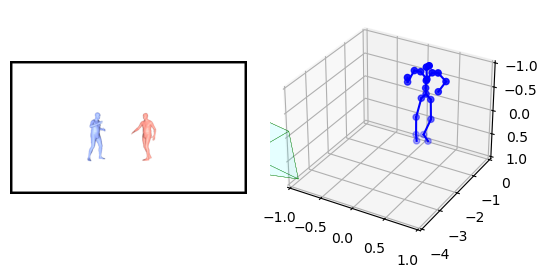

1
19.559172969951803


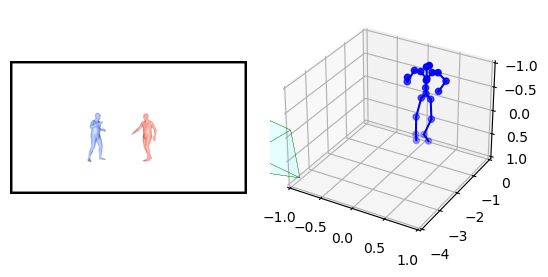

2
19.40878301411093


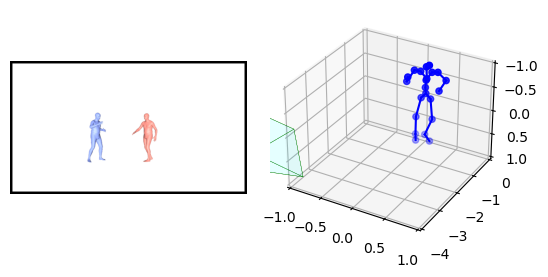

3
19.556253109851156


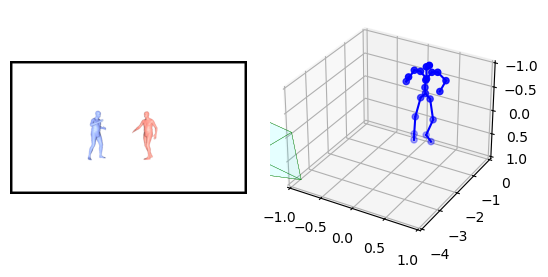

4
18.797868569893083


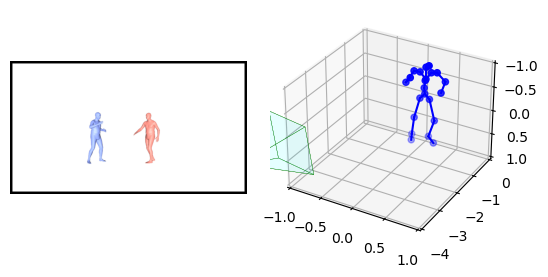

5
18.274501167912604


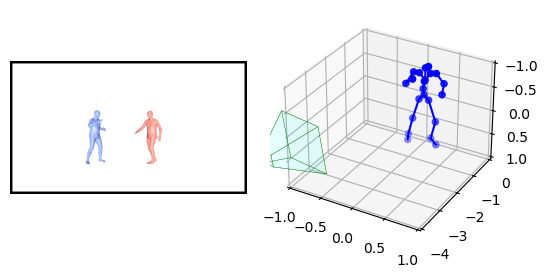

6
17.36515464865677


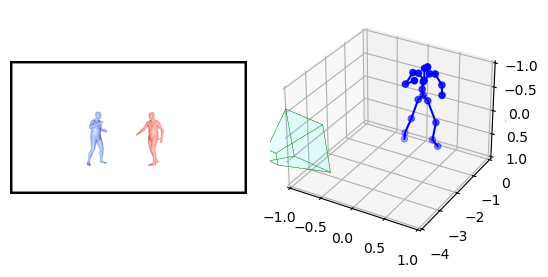

7
19.010017367046952


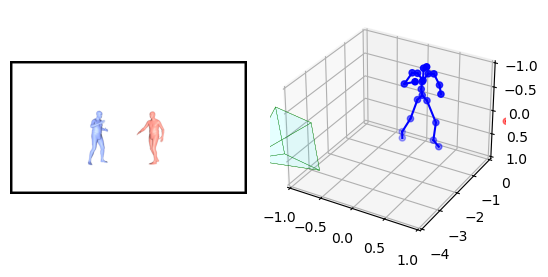

8
20.859810348269725


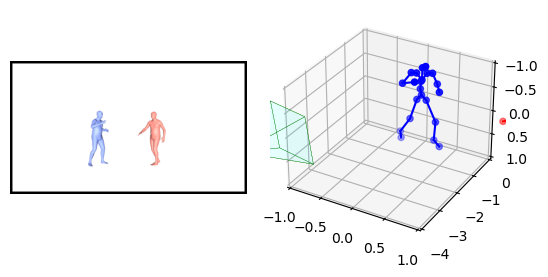

9
21.307287813308715


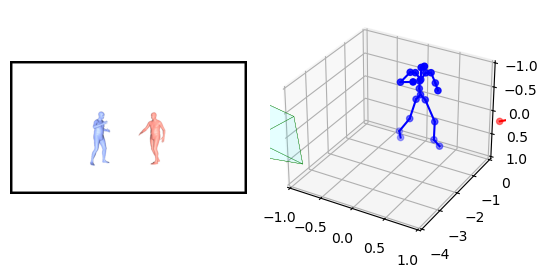

10
22.6285489274416


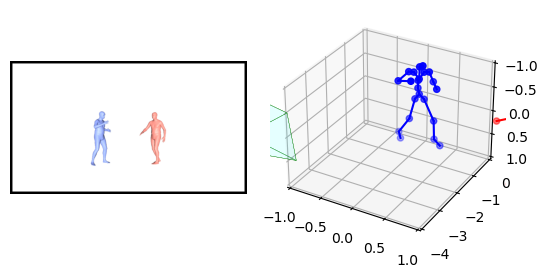

11
23.425198451878476


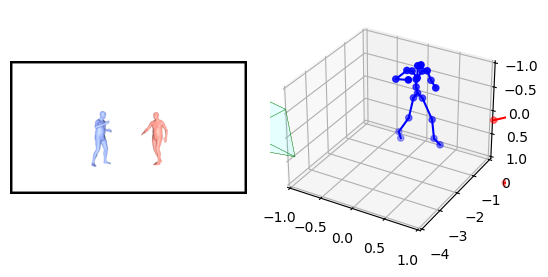

12
23.71274965857162


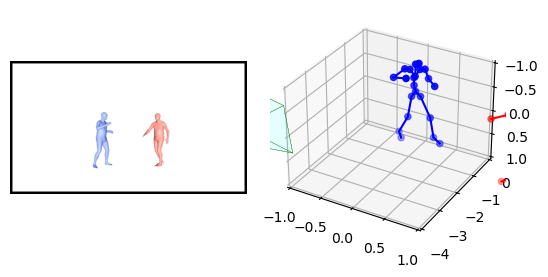

13
25.38831777599362


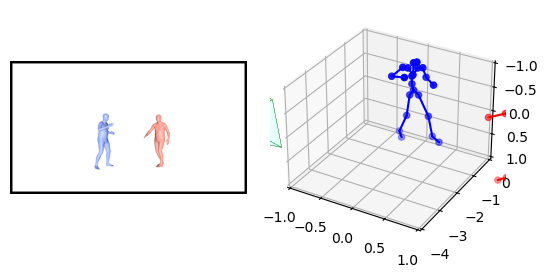

14
25.147304031499033


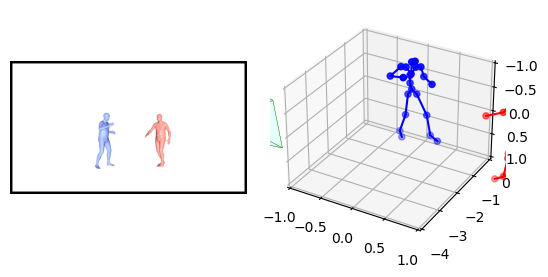

15
25.346118340422642


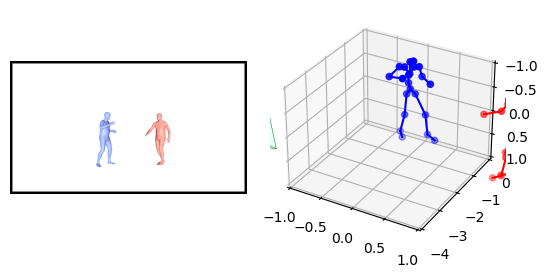

16
24.190225648798926


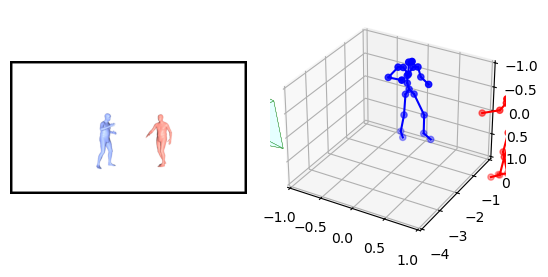

17
22.30409509339692


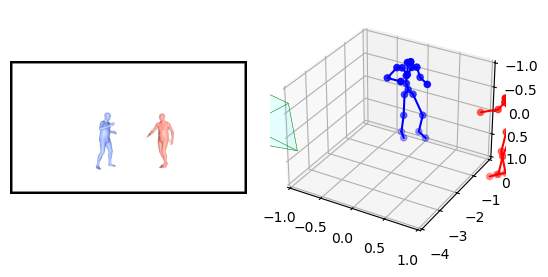

18
22.49085277013627


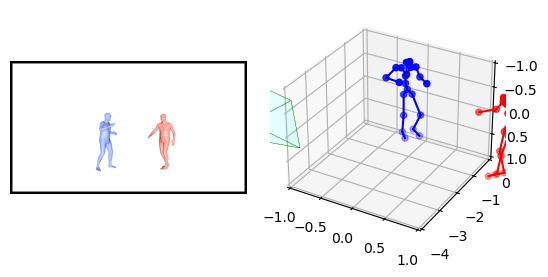

19
23.779430446131855


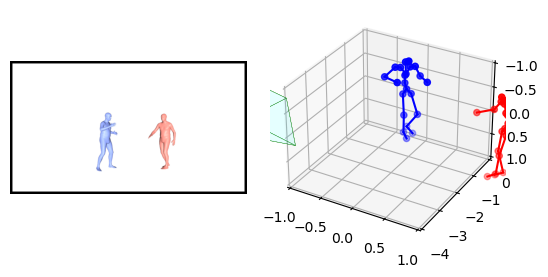

20
25.175737485216303


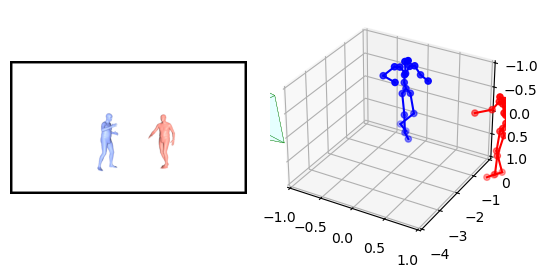

21
25.992915419471842


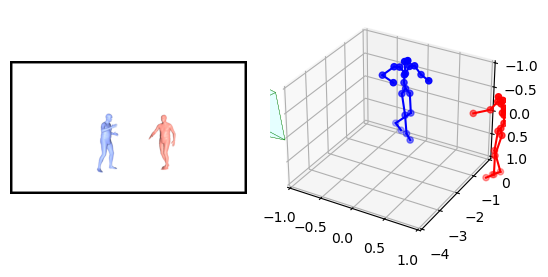

22
25.660820387780383


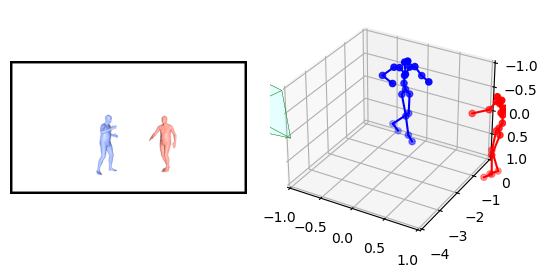

23
24.60299010404528


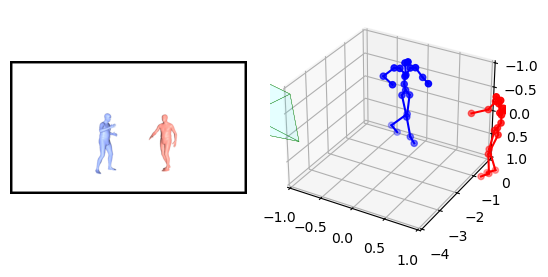

24
25.064355468276876


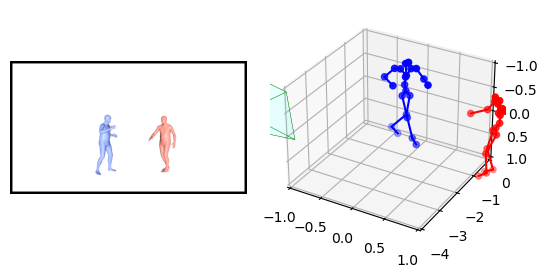

25
25.51393620699228


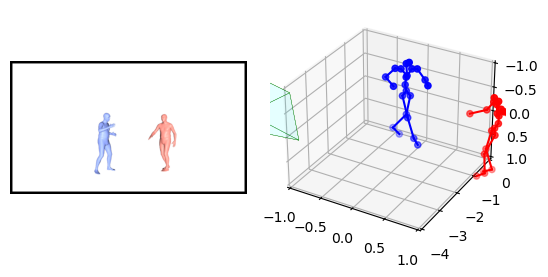

26
26.844627642106225


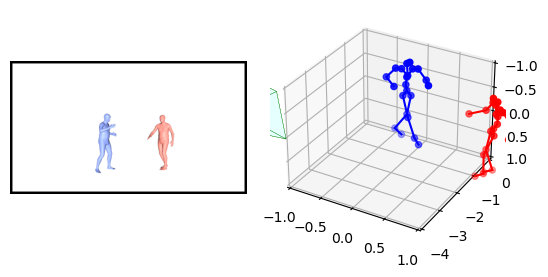

27
26.228562074943262


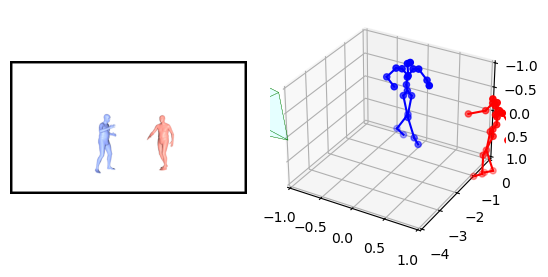

28
26.61061586503505


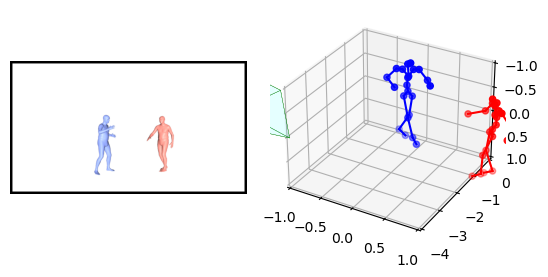

29
26.184192955179842


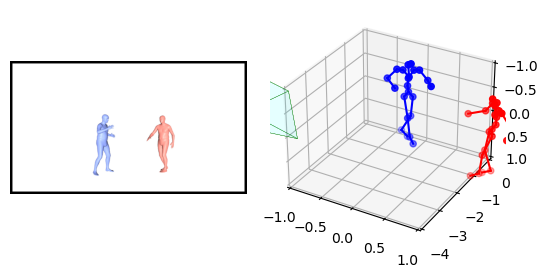

30
25.234629069800157


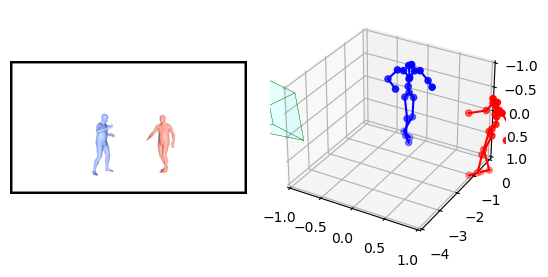

31
24.75361446616099


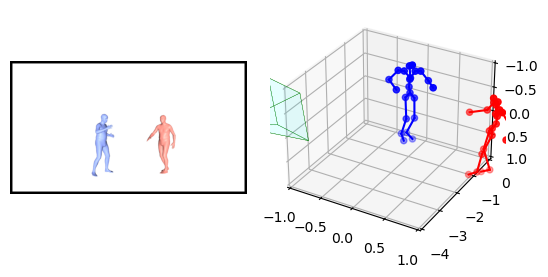

32
25.854994168780603


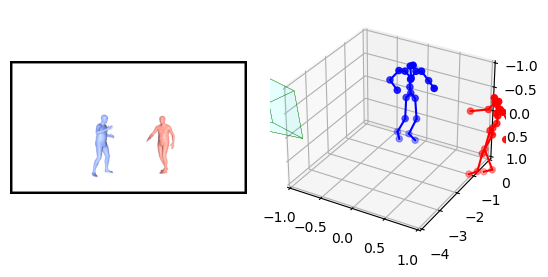

33
24.77600701030829


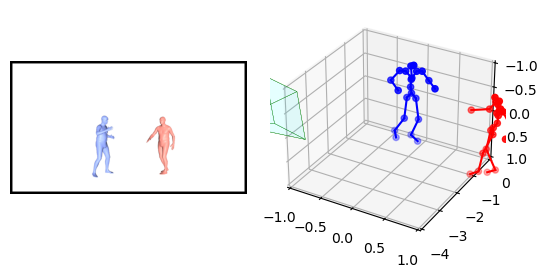

34
26.298537712934518


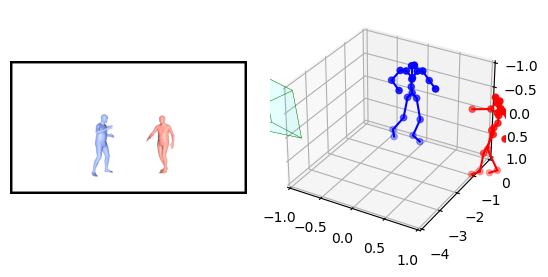

35
27.792368334860804


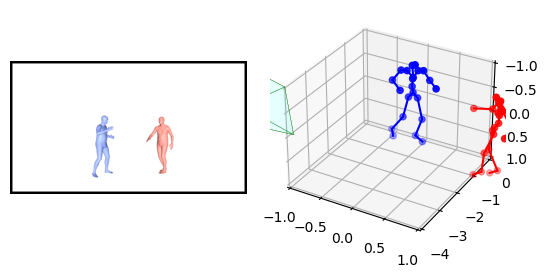

36
28.90249843048838


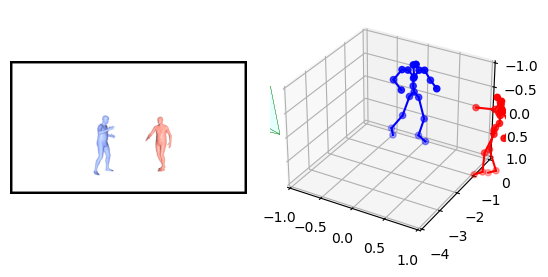

37
29.484280856442652


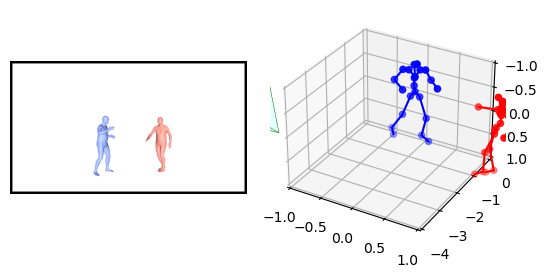

38
30.717845778372606


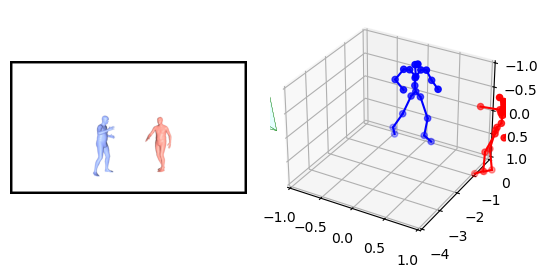

39
30.384825730939635


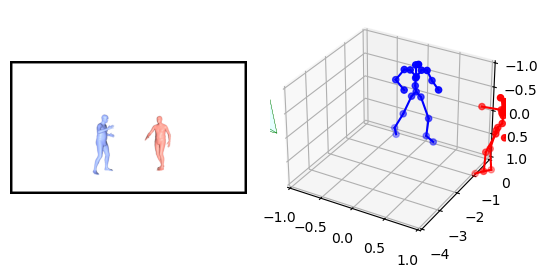

40
31.19312854304892


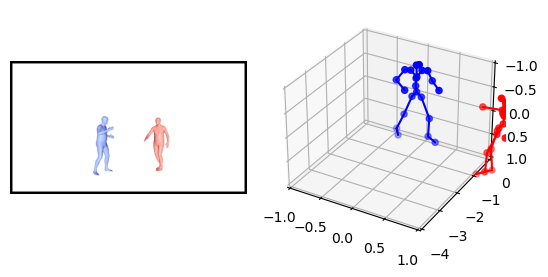

41
30.183690430494906


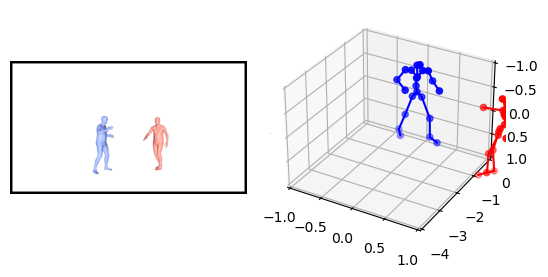

42
30.102997089828893


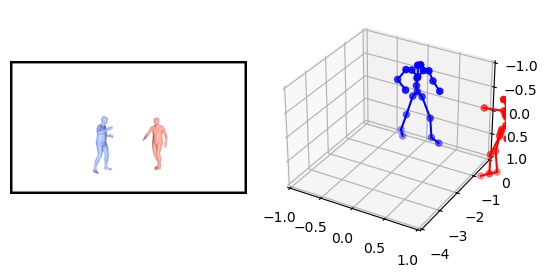

43
31.62745234088028


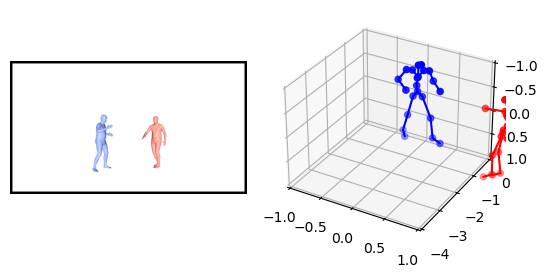

44
31.240135584980457


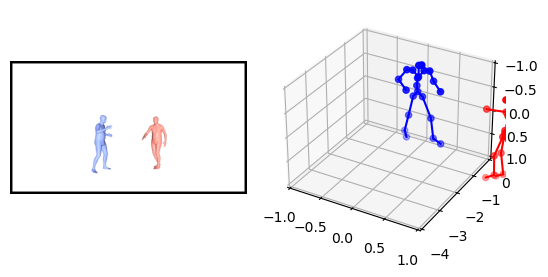

45
30.66776552267977


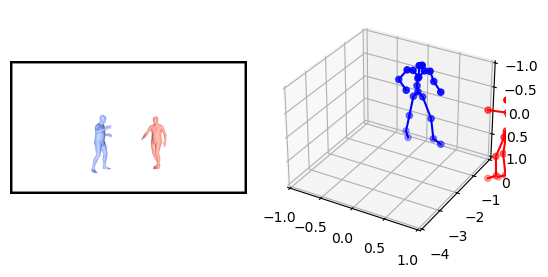

46
30.514843758763835


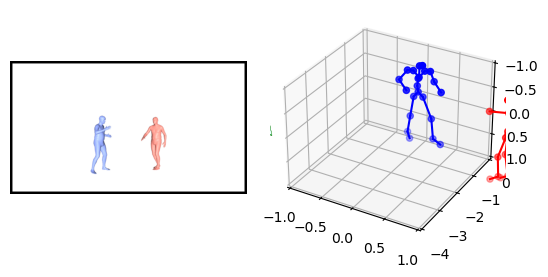

47
29.638481630115


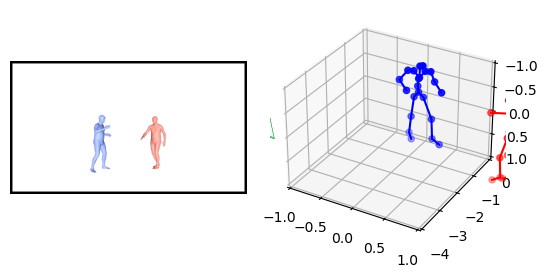

48
29.45936140888432


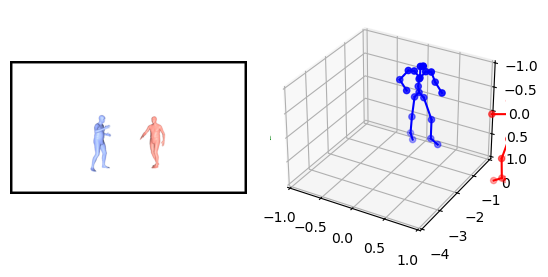

49
29.487134152820833


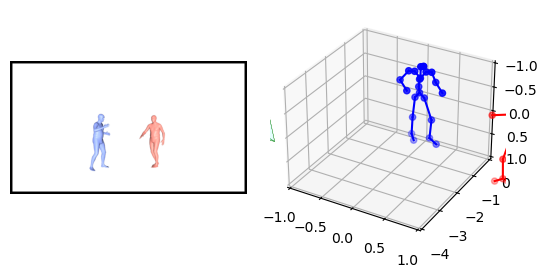

50
29.342462732449135


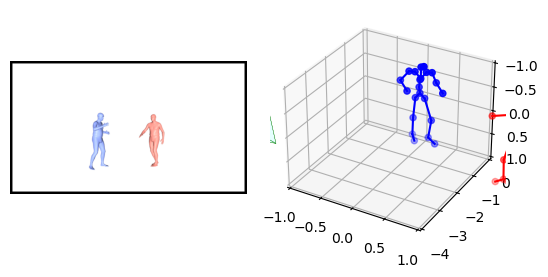

51
28.422806044904096


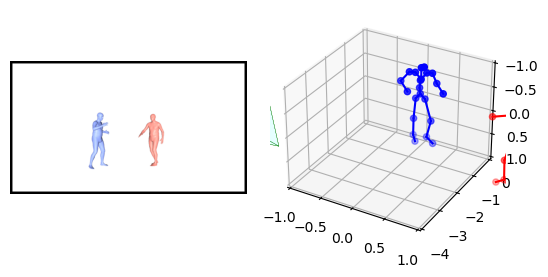

52
28.845525442545433


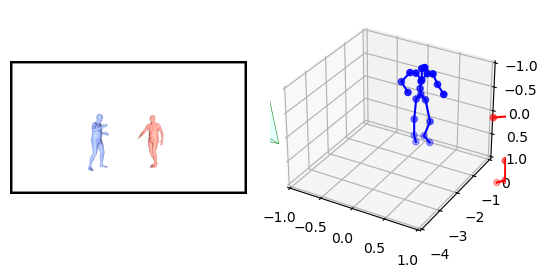

53
26.859723107558384


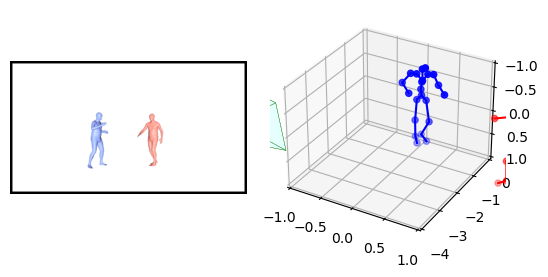

54
27.128246737176305


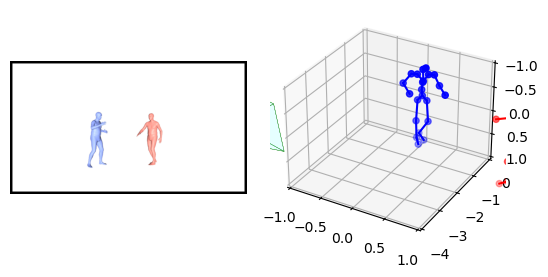

55
27.383465305639703


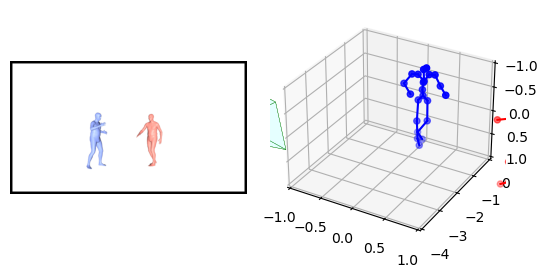

56
26.786609055480067


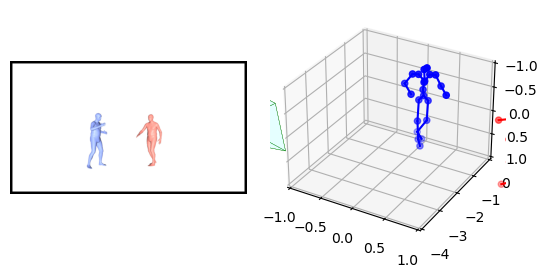

57
28.136690526554702


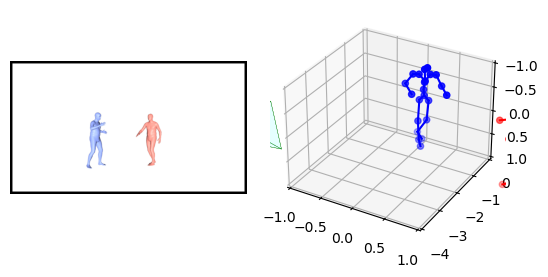

58
27.585329257382558


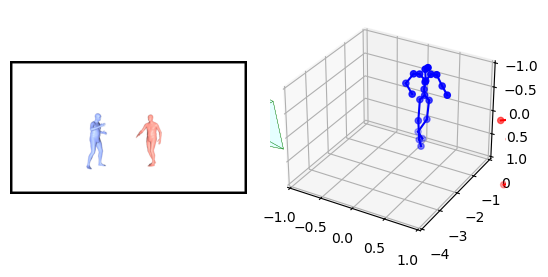

59
27.23877788619819


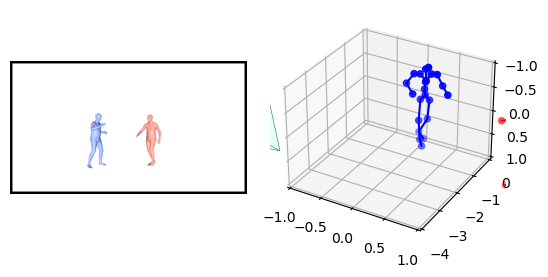

60
27.624044144675295


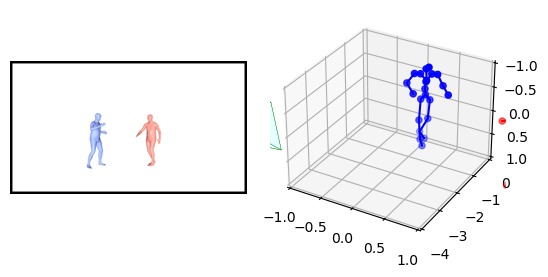

61
28.83987071779452


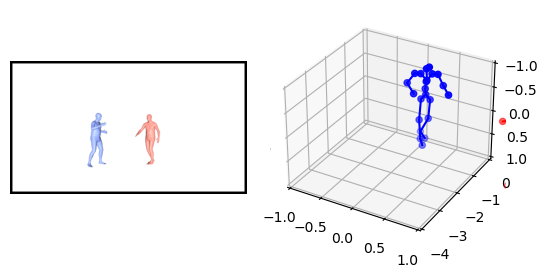

62
29.645321681079484


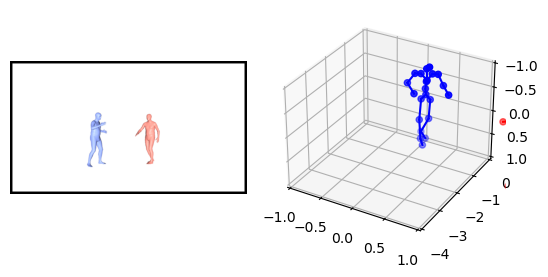

63
29.856879414502398


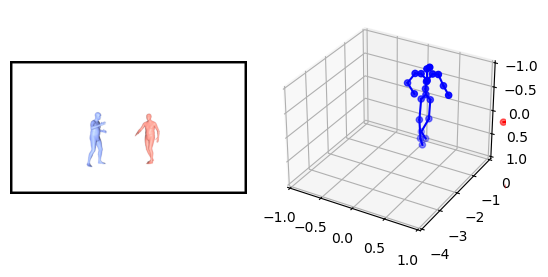

64
29.12680370568534


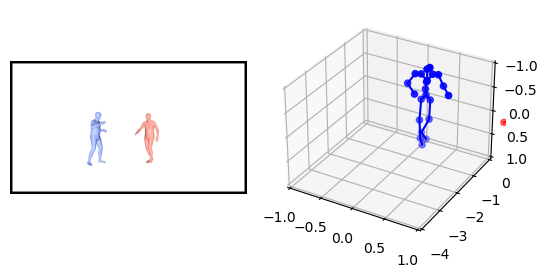

65
28.583289744729647


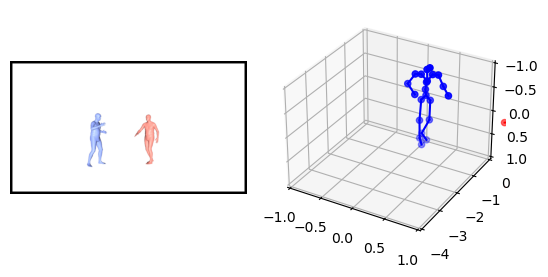

66
28.213694652603216


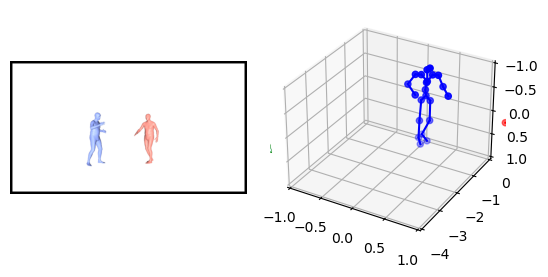

67
27.748164149569565


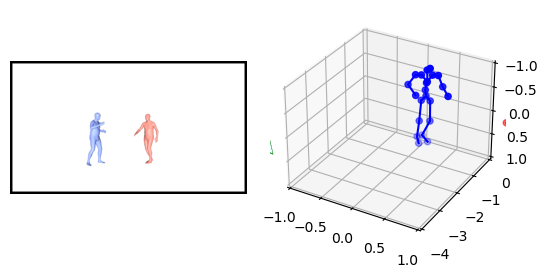

68
27.76643047419578


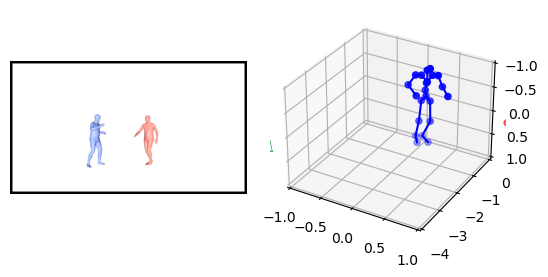

69
28.375306459181935


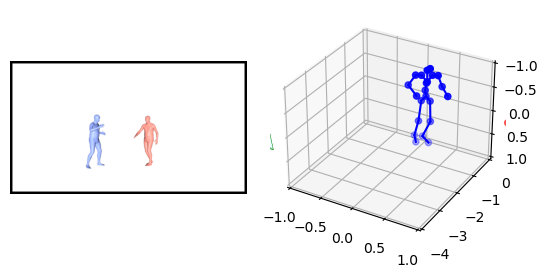

70
27.77752007341275


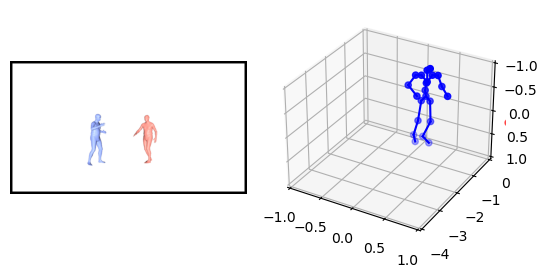

71
28.19937663731088


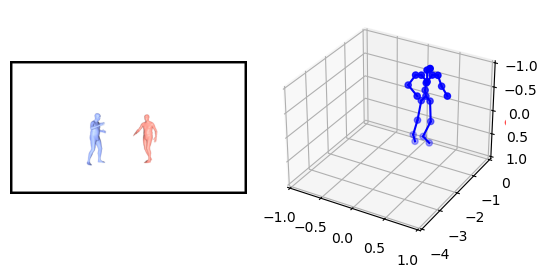

72
28.83680787242387


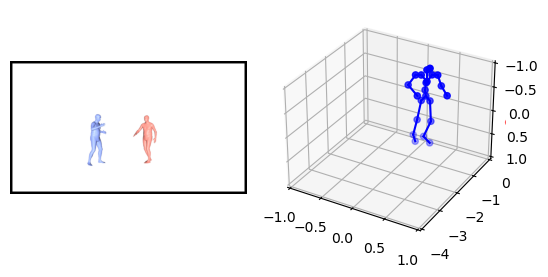

73
28.34937770951954


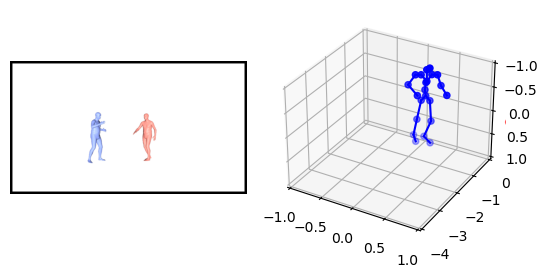

74
28.88079939449592


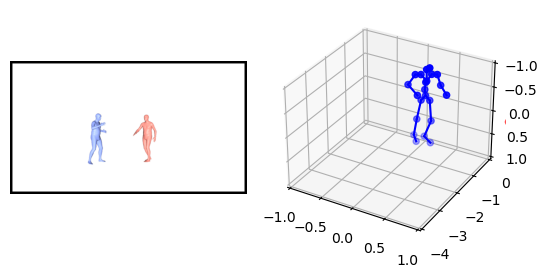

75
28.28830530457669


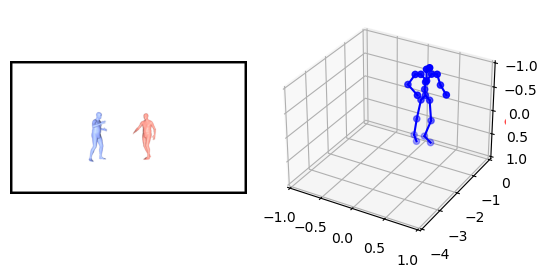

76
27.603256614222698


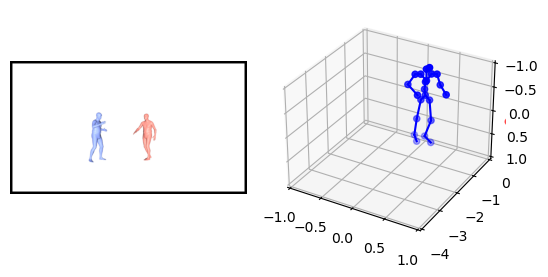

77
26.595310058394134


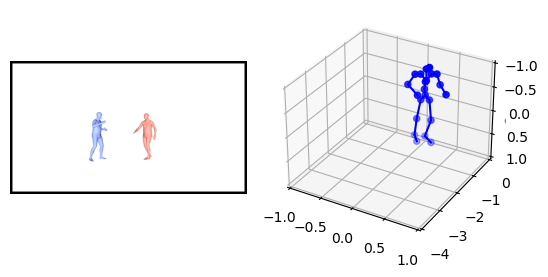

78
25.8595684009069


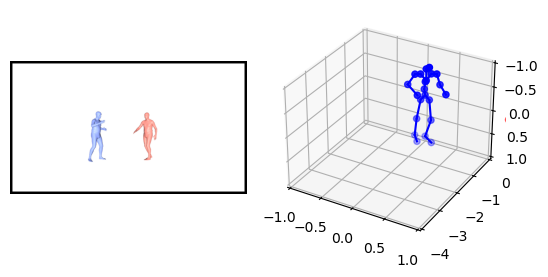

79
23.756498468790323


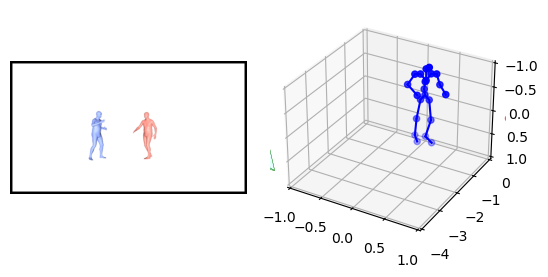

80
23.75497895507078


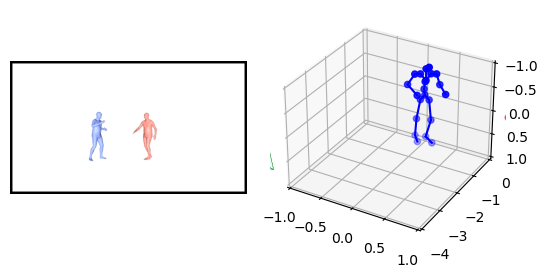

81
24.11670524593034


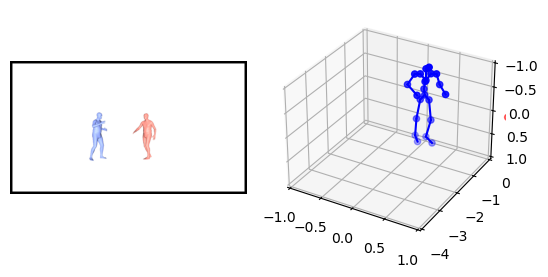

82
23.556943461582346


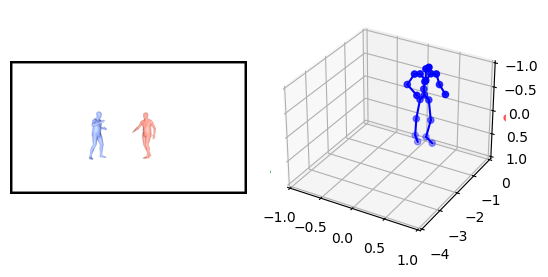

83
21.546174022882514


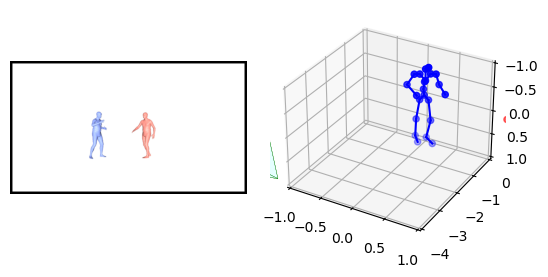

84
21.473805699355403


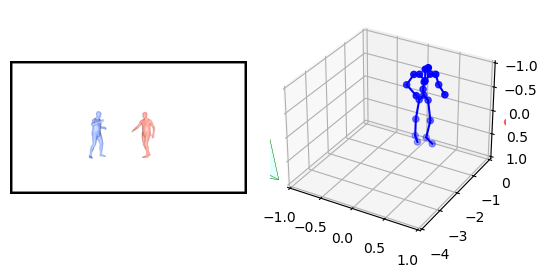

85
19.27534625212153


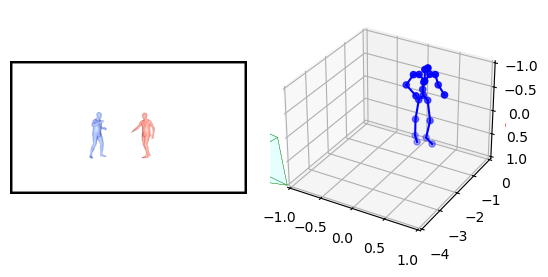

86
17.788219117290154


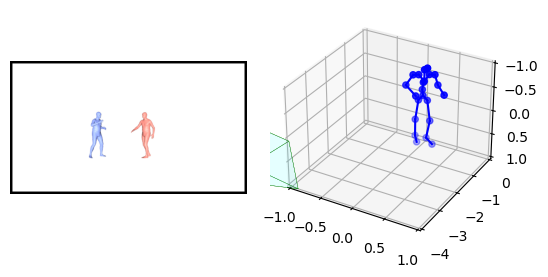

87
17.591838080763193


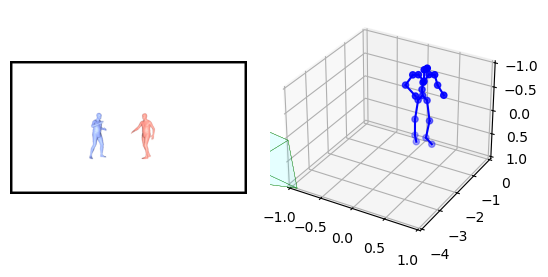

88
16.320171311510652


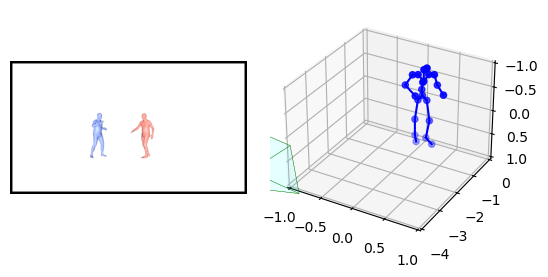

89
17.190998214639652


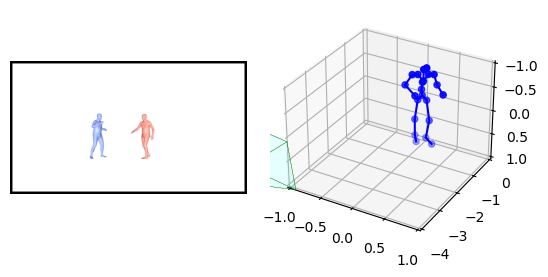

90
16.728440352191786


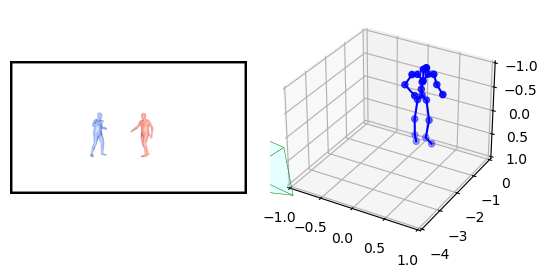

91
16.787608593525906


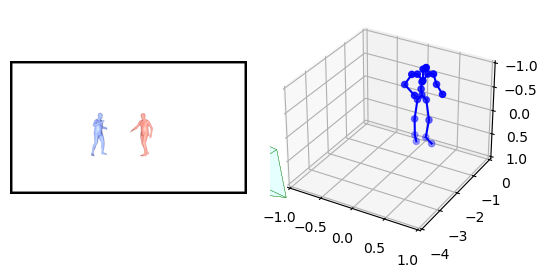

92
17.44824312623452


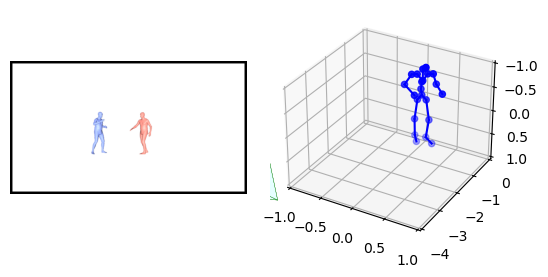

93
16.27716427569574


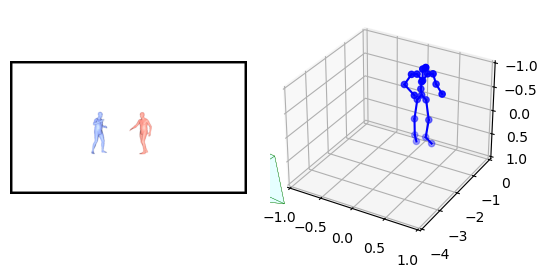

94
17.059489153653615


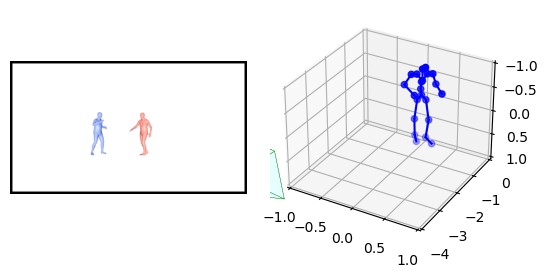

95
16.129762911696385


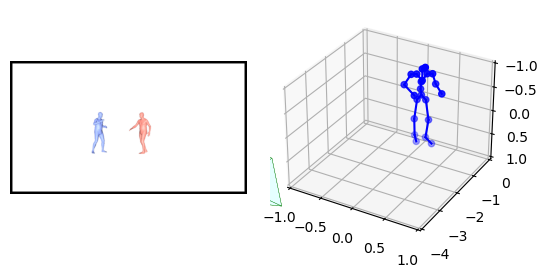

96
16.83950874746941


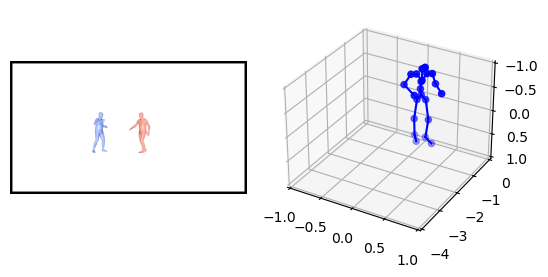

97
16.98034213119298


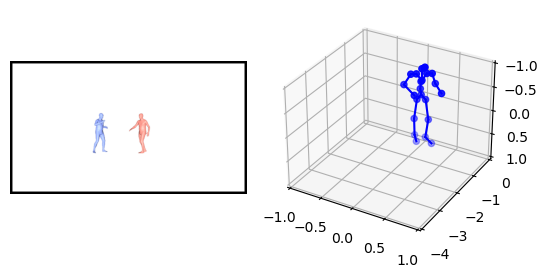

98
16.608810012475942


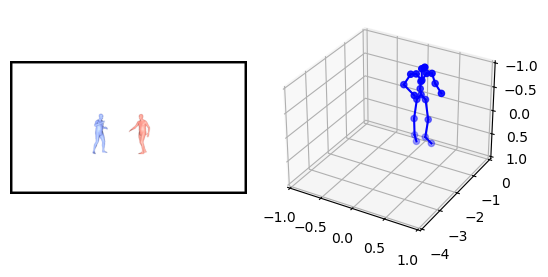

99
17.49291358447181


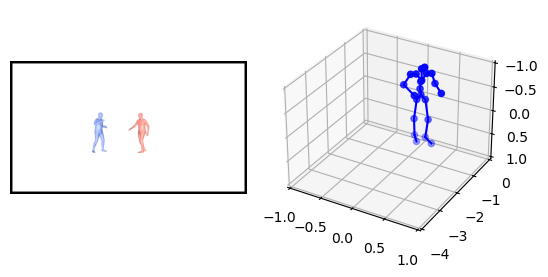

100
16.437023677192474


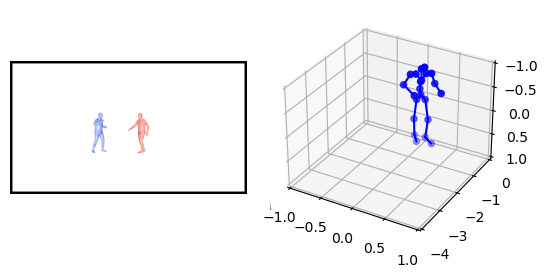

101
16.731819018494004


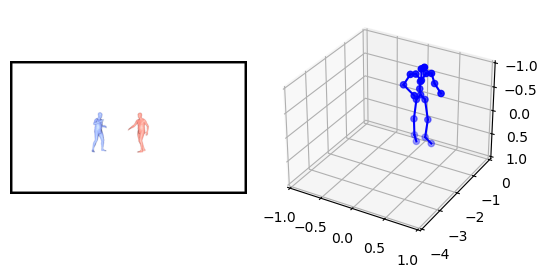

102
15.803232054644827


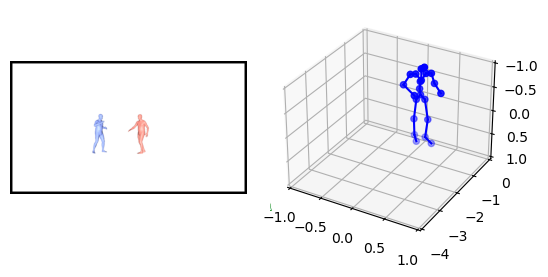

103
15.658382686272766


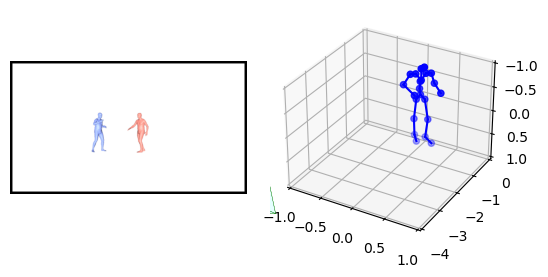

104
15.611269035275535


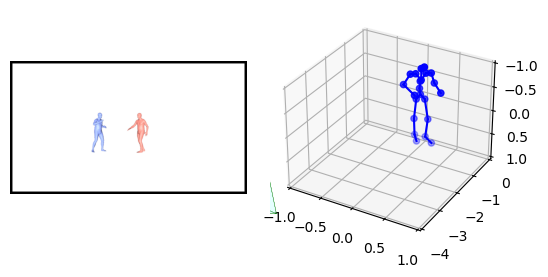

105
16.158766669813442


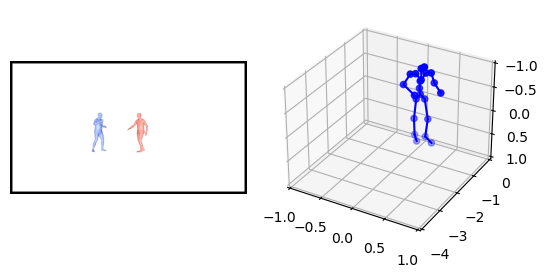

106
15.205989824334969


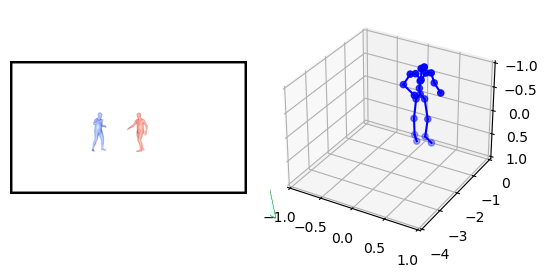

107
15.902825684744725


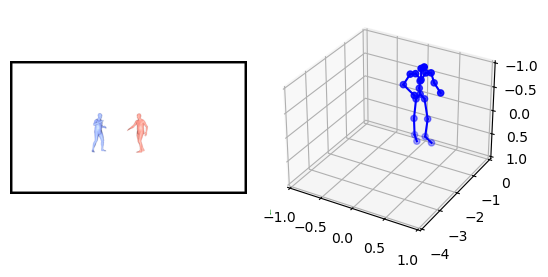

108
15.61860296072628


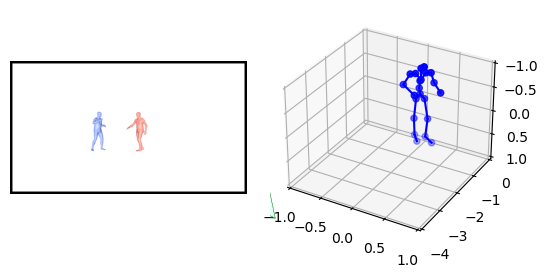

109
15.181632889248473


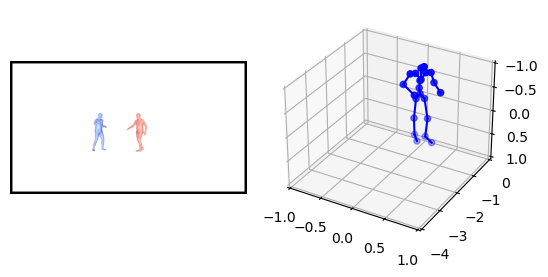

110
15.723978242268435


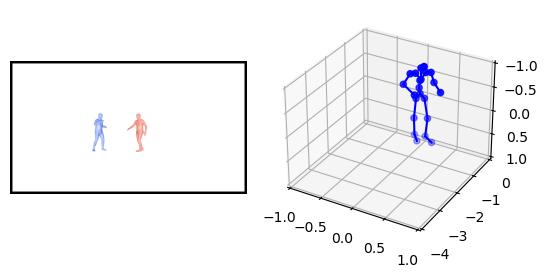

111
16.800436598376244


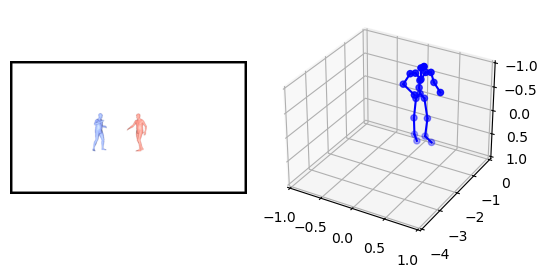

112
16.637880558109607


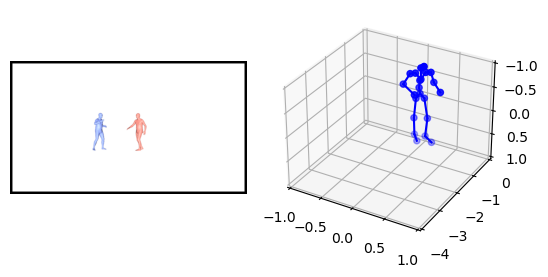

113
16.013984353472974


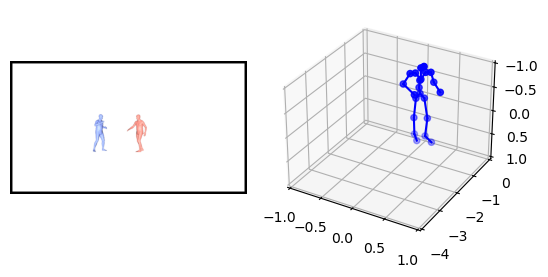

114
15.295506987738966


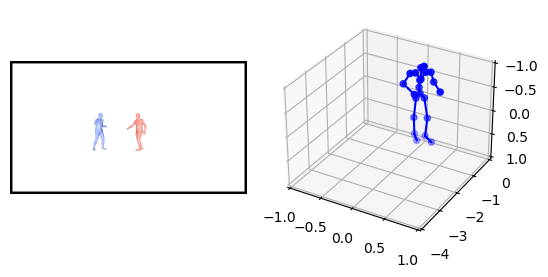

115
15.427636787785003


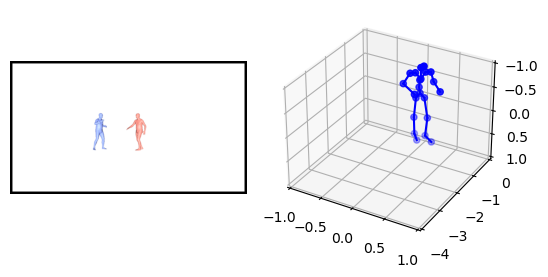

116
16.484096167159215


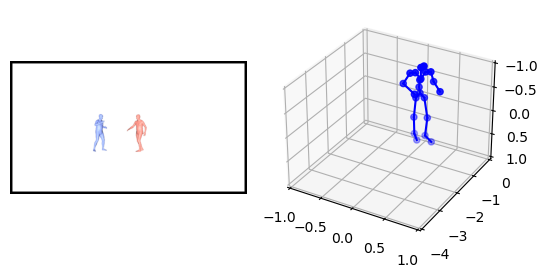

117
15.96620639216673


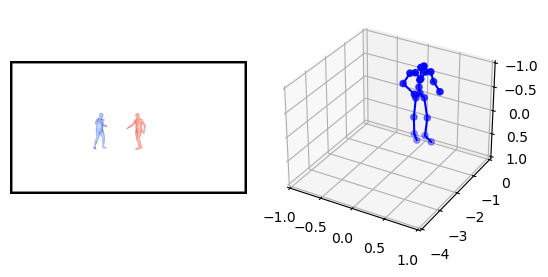

118
16.0864004661833


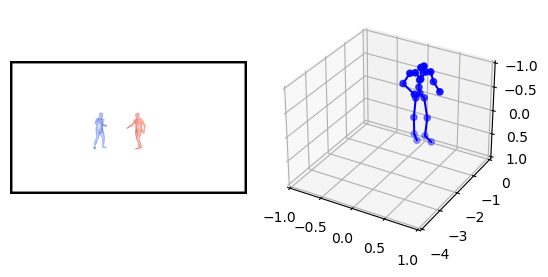

119
16.560627506170697


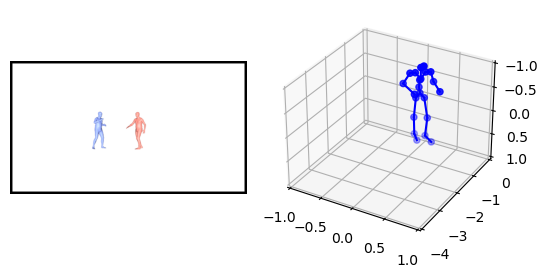

120


In [25]:
#Plot frame by frame
# left_joints_array = np.load("../Camera/generated_data/joint_cvt/0_p0_p0.npy")
# right_joints_array = np.load("../Camera/generated_data/joint_cvt/0_p0_p1.npy")
camera_array = np.load("../Camera/generated_data/camera/0.npy")
keys_to_convert = ['L2Dx', 'L2Dy', 'R2Dx', 'R2Dy', 'Theta', 'Phi']
desired_resolution = (960, 540)
dpi = 400  # Adjust the DPI to your needs
index = 0
camera_path = []
rotation_up = None

#遍历每一帧
for i in range(0,len(camera_array)):
    #i=119
    Camera_dic={}
    Camera = np.load("../Camera/generated_data/camera/0.npy")[i]
    for j, key in enumerate(keys_to_convert):
        Camera_dic[key] = float(Camera[j])    
    Camera_dic["FOV"] = 45 #相机水平视野 FOV=45°
    Camera_dic["Aspect"] = 1.67
    
    #Camera_dic["L2Dx"] = 0.5
    #Camera_dic["L2Dy"] = 0.5
    #Camera_dic["R2Dx"] = -0.5
    #Camera_dic["R2Dy"] = 0.5
    
    cam_angle = angle_between(np.array([Camera_dic["R2Dx"]-Camera_dic["L2Dx"], Camera_dic["R2Dy"]-Camera_dic["L2Dy"]]), 
                  np.array([1,0]))
    
    
    alpha = get_alpha(Camera_dic["FOV"], Camera_dic["Aspect"],
                [Camera_dic["L2Dx"], Camera_dic["L2Dy"]], [Camera_dic["R2Dx"], Camera_dic["R2Dy"]])
    
    #Camera_dic["Theta"] = np.pi-alpha
    #Camera_dic["Phi"] = -np.pi/12
        
    left_joints = np.load("../Camera/generated_data/joint_cvt/0_p0_p0.npy")[i]
    right_joints = np.load("../Camera/generated_data/joint_cvt/0_p0_p1.npy")[i]
    # 交换 Y/Z 维度
    left_joints[:,[1,2]]=left_joints[:,[2,1]]
    right_joints[:,[1,2]]=right_joints[:,[2,1]]
    # Y 轴取反
    left_joints[:,1]*=-1
    right_joints[:,1]*=-1
    #left_joints[:,2] *=   -1
    #right_joints[:,2] *=   -1

    #新建场景与刚体预处理
    scene = pyrender.Scene()
            

    for i, joint_position in enumerate(left_joints):
        left_joints[i][0] *= 1 
        left_joints[i][1] *= 1 
        left_joints[i][2] *= 1 
                # left_joints[i] -= new_system_origin

    for i, joint_position in enumerate(right_joints):
        right_joints[i][0] *= 1
        right_joints[i][1] *= 1 
        right_joints[i][2] *= 1 
                # right_joints[i] -= new_system_origin

    #设置相机节点及位姿
    camera = pyrender.PerspectiveCamera(yfov=np.deg2rad(45), aspectRatio=1.67)
            # Camera position and orientation
    cam_pose = np.array([
                [-1.0, 0.0, 0.0],
                [0.0, -1.0, 0.0],
                [0.0, 0.0, -1.0],
            ])
            # print(left_joints[15])
            # print(right_joints[15])
            # print(Camera_dic)

     #确定“观看目标”点
    if (left_joints[15] == right_joints[15]).all():
        left_person = left_joints[17]
        right_person = left_joints[16]
        left = left_person if left_person[0] < right_person[0] else right_person
        right = right_person if left_person[0] < right_person[0] else left_person
    else:
        left = left_joints[15]
        right = right_joints[15]
    new_camera_pos = toric2euclidean(Camera_dic, left, right)
    look_at_angle = angle_between(np.array([0.0, 0.0, 1.0]), (left+right)/2-new_camera_pos)

    #应用位姿并添加到场景
    cam_new_pose = np.eye(4)
    cam_new_pose[:3, :3] = cam_pose #@rotation_matrix_x(-Camera_dic["Phi"]/2)@rotation_matrix_y(-look_at_angle)
    cam_new_pose[:3, 3] = new_camera_pos
    camera_node = scene.add(camera, pose=cam_new_pose)
        # cam_new_pose[:3, 3] = np.array([0.0,0.0,0.0]) - new_system_origin
    #print(new_camera_pos)
            # print(new_system_origin)
            # print(new_camera_pos, "----------", np.array([0.0,0.0,0.0]) - new_system_origin)

            # Add the camera to the scene

    #进一步绕局部轴旋转
    pose = camera_node.matrix  
    angle_deg = look_at_angle/np.pi*180
    print(angle_deg)
    rot_local = R.from_euler('y', angle_deg, degrees=True).as_matrix()
    rot_local_4x4 = np.eye(4)
    rot_local_4x4[:3, :3] = rot_local
    new_pose = pose @ rot_local_4x4  
    scene.set_pose(camera_node, new_pose)
    
    
    pose = camera_node.matrix  

    rot_local = R.from_euler('x', Camera_dic["Phi"]/2, degrees=True).as_matrix()
    rot_local_4x4 = np.eye(4)
    rot_local_4x4[:3, :3] = rot_local
    new_pose = pose @ rot_local_4x4  
    scene.set_pose(camera_node, new_pose)     
    
    #添加光源
    light = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=5.0)
    scene.add(light, pose=new_pose)
    
    
    human_angle = np.pi / 2  # 90 degrees
    human_rotation_x = trimesh.transformations.rotation_matrix(
                    human_angle, direction=[1, 0, 0], point=[0, 0, 0]
                    )

    #加载人物网格并放入场景
    #mesh部分引用自https://github.com/wangsen1312/joints2smpl
    #作者wangsen1312 
    p1_mesh = trimesh.load('joints2smpl-main/demo/demo_results/0_p0_p0/0009.ply')
    p2_mesh = trimesh.load('joints2smpl-main/demo/demo_results/0_p0_p1/0009.ply')
    material_1 = pyrender.MetallicRoughnessMaterial(baseColorFactor=[1.0, 0.4, 0.3, 1.0],  # 颜色
                                                    metallicFactor=0.0,                
                                                    roughnessFactor=0.5 )
    material_2 = pyrender.MetallicRoughnessMaterial(baseColorFactor=[0.25, 0.3, 1.0, 1.0],  # 颜色
                                                    metallicFactor=0.0,                
                                                    roughnessFactor=0.5)
    pyrender_mesh_p1 = pyrender.Mesh.from_trimesh(p1_mesh, material=material_1)
    pyrender_mesh_p2 = pyrender.Mesh.from_trimesh(p2_mesh, material=material_2)
    scene.add(pyrender_mesh_p1,pose=human_rotation_x)
    scene.add(pyrender_mesh_p2,pose=human_rotation_x)

    #绘制关节（球体）与骨骼（圆柱）
    # material = pyrender.MetallicRoughnessMaterial(baseColorFactor=[0.0, 0.0, 1.0, 1.0])
    # for i, joint_position in enumerate(right_joints):
    #             # right_joints[i][0] *= 1 / 1000
    #             # right_joints[i][1] *= 1 / 1000
    #             # right_joints[i][2] *= 1 / 1000
    #             # right_joints[i] -= new_system_origin
    #     joint_mesh = trimesh.creation.icosphere(radius=0.03, subdivisions=2)
    #     joint_mesh.apply_translation(right_joints[i])
    #     scene.add(pyrender.Mesh.from_trimesh(joint_mesh, material=material))
    #             # print(right_joints[i])
    # for connection in connections:
    #             # print(connection[0], connection[1])
    #             # print(right_joints[connection[0]], right_joints[connection[1]])
    #     cylinder = create_cylinder_between_points(right_joints[connection[0]], right_joints[connection[1]], 0.01)
    #     scene.add(pyrender.Mesh.from_trimesh(cylinder, material=material))

    if rotation_up is None:
        spine_up = right_joints[9] - right_joints[6]
        spine_up /= np.linalg.norm(spine_up)
        original_up = np.array([0.0, -1.0, 0.0])
        spine_up = original_up
        rotation_axis = np.cross(spine_up, original_up)
        angle = np.arccos(np.dot(original_up, spine_up))
        rotation_vector = rotation_axis * angle
        rotation_up = R.from_rotvec(rotation_vector)
                # print(angle)

    for i, joint_position in enumerate(right_joints):
        right_joints[i] = rotation_up.apply(joint_position)

    # material = pyrender.MetallicRoughnessMaterial(baseColorFactor=[1.0, 0.0, 0.0, 1.0])
    # for i, joint_position in enumerate(left_joints):
    #             # left_joints[i][0] *= 1 / 1000
    #             # left_joints[i][1] *= 1 / 1000
    #             # left_joints[i][2] *= 1 / 1000
    #             # left_joints[i] -= new_system_origin
    #     joint_mesh = trimesh.creation.icosphere(radius=0.03, subdivisions=2)
    #     joint_mesh.apply_translation(left_joints[i])
    #     scene.add(pyrender.Mesh.from_trimesh(joint_mesh, material=material))
    #             # left_joints[i] = np.dot(rotation, left_joints[i])
    #             # joint_mesh = trimesh.creation.icosphere(radius=0.03, subdivisions=2)
    #             # joint_mesh.apply_translation(np.dot(rotation, left_joints[i] - new_system_origin))
    #             # scene.add(pyrender.Mesh.from_trimesh(joint_mesh, material = material))
    # for connection in connections:
    #     cylinder = create_cylinder_between_points(left_joints[connection[0]], left_joints[connection[1]], 0.01)
    #     scene.add(pyrender.Mesh.from_trimesh(cylinder, material=material))

    # for i, joint_position in enumerate(left_joints):
    #     left_joints[i] = rotation_up.apply(joint_position)

            # Set up the renderer with a specific resolution

    # 离屏渲染并后处理
    renderer = pyrender.OffscreenRenderer(viewport_width=960, viewport_height=540)

            # Render the scene
    color, depth = renderer.render(scene)

            # Define the thickness of the frame border
    border_thickness = 10  # Adjust this value to your preference
    color = np.array(color)
    color = np.flip(color)

            # Create the black frame by manipulating the color array
            # Set the border rows and columns to black
    color[:border_thickness, :, :] = 0  # Top border
    color[-border_thickness:, :, :] = 0  # Bottom border
    color[:, :border_thickness, :] = 0  # Left border
    color[:, -border_thickness:, :] = 0  # Right border

    #可视化
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ## 左子图：渲染图像
    ax2 = fig.add_subplot(121)
    ax2.imshow(color)
    ax2.axis('off')
    ## 右子图：3D 骨骼 + 相机轨迹
    ax = fig.add_subplot(122, projection='3d')
    ax.set_aspect('auto')
    x_limits = [-1, 1]
    y_limits = [-4, 0]
    z_limits = [1, -1]

    ax.set_xlim(x_limits)
    ax.set_zlim(z_limits)
    ax.set_ylim(y_limits)

    ax.plot(right_joints[:2, 0], right_joints[:2, 2], right_joints[:2, 1], c="red")
    ax.plot(right_joints[:3:2, 0], right_joints[:3:2, 2], right_joints[:3:2, 1], c="red")
    ax.plot(right_joints[:4:3, 0], right_joints[:4:3, 2], right_joints[:4:3, 1], c="red")
    ax.plot(right_joints[1:5:3, 0], right_joints[1:5:3, 2], right_joints[1:5:3, 1], c="red")
    ax.plot(right_joints[2:6:3, 0], right_joints[2:6:3, 2], right_joints[2:6:3, 1], c="red")
    ax.plot(right_joints[3:7:3, 0], right_joints[3:7:3, 2], right_joints[3:7:3, 1], c="red")
    ax.plot(right_joints[4:8:3, 0], right_joints[4:8:3, 2], right_joints[4:8:3, 1], c="red")
    ax.plot(right_joints[5:9:3, 0], right_joints[5:9:3, 2], right_joints[5:9:3, 1], c="red")
    ax.plot(right_joints[6:10:3, 0], right_joints[6:10:3, 2], right_joints[6:10:3, 1], c="red")
    ax.plot(right_joints[7:11:3, 0], right_joints[7:11:3, 2], right_joints[7:11:3, 1], c="red")
    ax.plot(right_joints[8:12:3, 0], right_joints[8:12:3, 2], right_joints[8:12:3, 1], c="red")
    ax.plot(right_joints[9:13:3, 0], right_joints[9:13:3, 2], right_joints[9:13:3, 1], c="red")
    ax.plot(right_joints[9:14:4, 0], right_joints[9:14:4, 2], right_joints[9:14:4, 1], c="red")
    ax.plot(right_joints[9:15:5, 0], right_joints[9:15:5, 2], right_joints[9:15:5, 1], c="red")
    ax.plot(right_joints[12:16:3, 0], right_joints[12:16:3, 2], right_joints[12:16:3, 1], c="red")
    ax.plot(right_joints[14:18:3, 0], right_joints[14:18:3, 2], right_joints[14:18:3, 1], c="red")
    ax.plot(right_joints[13:17:3, 0], right_joints[13:17:3, 2], right_joints[13:17:3, 1], c="red")
    ax.plot(right_joints[16:19:2, 0], right_joints[16:19:2, 2], right_joints[16:19:2, 1], c="red")
    ax.plot(right_joints[17:20:2, 0], right_joints[17:20:2, 2], right_joints[17:20:2, 1], c="red")
    ax.plot(right_joints[18:21:2, 0], right_joints[18:21:2, 2], right_joints[18:21:2, 1], c="red")
    ax.plot(right_joints[19:22:2, 0], right_joints[19:22:2, 2], right_joints[19:22:2, 1], c="red")
    ax.plot(right_joints[20:23:2, 0], right_joints[20:23:2, 2], right_joints[20:23:2, 1], c="red")
    ax.plot(right_joints[21:24:2, 0], right_joints[21:24:2, 2], right_joints[21:24:2, 1], c="red")
    if (left_joints[15] != right_joints[15]).all():
        ax.plot(left_joints[:2, 0], left_joints[:2, 2], left_joints[:2, 1], c="blue")
        ax.plot(left_joints[:3:2, 0], left_joints[:3:2, 2], left_joints[:3:2, 1], c="blue")
        ax.plot(left_joints[:4:3, 0], left_joints[:4:3, 2], left_joints[:4:3, 1], c="blue")
        ax.plot(left_joints[1:5:3, 0], left_joints[1:5:3, 2], left_joints[1:5:3, 1], c="blue")
        ax.plot(left_joints[2:6:3, 0], left_joints[2:6:3, 2], left_joints[2:6:3, 1], c="blue")
        ax.plot(left_joints[3:7:3, 0], left_joints[3:7:3, 2], left_joints[3:7:3, 1], c="blue")
        ax.plot(left_joints[4:8:3, 0], left_joints[4:8:3, 2], left_joints[4:8:3, 1], c="blue")
        ax.plot(left_joints[5:9:3, 0], left_joints[5:9:3, 2], left_joints[5:9:3, 1], c="blue")
        ax.plot(left_joints[6:10:3, 0], left_joints[6:10:3, 2], left_joints[6:10:3, 1], c="blue")
        ax.plot(left_joints[7:11:3, 0], left_joints[7:11:3, 2], left_joints[7:11:3, 1], c="blue")
        ax.plot(left_joints[8:12:3, 0], left_joints[8:12:3, 2], left_joints[8:12:3, 1], c="blue")
        ax.plot(left_joints[9:13:3, 0], left_joints[9:13:3, 2], left_joints[9:13:3, 1], c="blue")
        ax.plot(left_joints[9:14:4, 0], left_joints[9:14:4, 2], left_joints[9:14:4, 1], c="blue")
        ax.plot(left_joints[9:15:5, 0], left_joints[9:15:5, 2], left_joints[9:15:5, 1], c="blue")
        ax.plot(left_joints[12:16:3, 0], left_joints[12:16:3, 2], left_joints[12:16:3, 1], c="blue")
        ax.plot(left_joints[14:18:3, 0], left_joints[14:18:3, 2], left_joints[14:18:3, 1], c="blue")
        ax.plot(left_joints[13:17:3, 0], left_joints[13:17:3, 2], left_joints[13:17:3, 1], c="blue")
        ax.plot(left_joints[16:19:2, 0], left_joints[16:19:2, 2], left_joints[16:19:2, 1], c="blue")
        ax.plot(left_joints[17:20:2, 0], left_joints[17:20:2, 2], left_joints[17:20:2, 1], c="blue")
        ax.plot(left_joints[18:21:2, 0], left_joints[18:21:2, 2], left_joints[18:21:2, 1], c="blue")
        ax.plot(left_joints[19:22:2, 0], left_joints[19:22:2, 2], left_joints[19:22:2, 1], c="blue")
        ax.plot(left_joints[20:23:2, 0], left_joints[20:23:2, 2], left_joints[20:23:2, 1], c="blue")
        ax.plot(left_joints[21:24:2, 0], left_joints[21:24:2, 2], left_joints[21:24:2, 1], c="blue")
        ax.scatter(left_joints[:24, 0], left_joints[:24, 2], left_joints[:24, 1], c="blue")
    ax.scatter(right_joints[:24, 0], right_joints[:24, 2], right_joints[:24, 1], c="red")
            # ax.scatter(left_joints[:24, 0], left_joints[:24, 2], left_joints[:24, 1], c="blue")

            # draw_camera_frustum(ax, [0.0, 0.0,0.0], cam_pose)
            # print(Camera_dic, left_joints[15], right_joints[15])
            # print(Camera_dic)
            # print(left_joints[15])
            # print(right_joints[15])
    new_camera_pos = toric2euclidean(Camera_dic, left, right)
            # print("dfff:",cam_new_pose[:3, 3])
            # print("ddfg:",left_joints[15], right_joints[15])

    origin_size = 25  # Size of the marker for the origin
            # camera_cur_pos = np.array([0.0, 0.0, 0.0]) - new_system_origin
    camera_cur_pos = new_camera_pos
            # print(camera_cur_pos)
            # assert 1==2
            # camera_cur_pos = np.dot(rotation_matrix, camera_cur_pos)
    camera_path.append(camera_cur_pos)
    for i, camera_pos in enumerate(camera_path):
        fade_value = (i + 1) / len(camera_path)
        rot_trans = toric2rotation(Camera_dic, np.array([camera_pos[0], camera_pos[1], camera_pos[2]]),
                                           left, right)
        camera_pos = rotation_up.apply(camera_pos)
                # print(camera_pos)
                # print(left_joints[15])
                # print(right_joints[15])
                # shot_type = predict_shot_type(camera_pos, left_joints[15], right_joints[15])   #判断景别
                # print(shot_type)
                # assert 1==2
        ax.scatter(camera_pos[0], camera_pos[2], camera_pos[1], color="green", marker='.', s=origin_size,
                           depthshade=True, alpha=fade_value)
        if i == len(camera_path) - 1:
            draw_camera_viewing_cone(ax, camera_cur_pos, rot_trans, rotation_up)

            # print(new_camera_pos, left_joints[3], right_joints[3])

    #保存与清理
    plt.subplots_adjust(wspace=0.1, hspace=0)
    #plt.savefig(f"frames/camera_2/{index}.jpg", dpi=dpi, bbox_inches='tight', pad_inches=0)
    plt.savefig(f"Visualize/0119.jpg", dpi=dpi, bbox_inches='tight', pad_inches=0)
    plt.show()
    
    file_name = "camera_frames"
    output_dir = f"Visualize/{file_name}"
    os.makedirs(output_dir, exist_ok=True)
    imageio.imwrite(f"{output_dir}/{index}.jpg", color)

    # imageio.imwrite(f"Visualize/{file_name}/{index}.jpg", color)
    index += 1
    print(index)
            # Clean up the renderer
    renderer.delete()

In [24]:
camera_array

array([[-0.30768512,  0.31243374,  0.2329901 ,  0.31057308,  3.01045593,
         0.06976737],
       [-0.30940005,  0.31019305,  0.23231448,  0.3083856 ,  3.00625168,
         0.06675517],
       [-0.30498352,  0.30942485,  0.24002354,  0.30701209,  2.99294838,
         0.06667869],
       [-0.30140884,  0.30938017,  0.23610066,  0.305567  ,  2.98731087,
         0.07694772],
       [-0.31051199,  0.30701523,  0.24131537,  0.31073698,  2.95887644,
         0.06490051],
       [-0.31707735,  0.30170463,  0.24730642,  0.31312428,  2.94681681,
         0.07264916],
       [-0.31134004,  0.29628997,  0.24825502,  0.30109043,  2.92683956,
         0.06171528],
       [-0.3170078 ,  0.29090595,  0.23394507,  0.29907175,  2.9535798 ,
         0.06462104],
       [-0.31593496,  0.29002932,  0.2455763 ,  0.29572851,  2.95455292,
         0.0621317 ],
       [-0.31055659,  0.28927256,  0.23689793,  0.30164679,  2.92616548,
         0.05796861],
       [-0.30854319,  0.29420688,  0.24115293,  0.